In [72]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,60

In [9]:
cpdb = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/cpdb_microglia_EC_communication/cpdb_out/significant_means.txt', delimiter = "\t",index_col=0)
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20211111_with_obsp.h5ad')

In [144]:
# list(adata.obs['cell.labels'].unique())

In [138]:
cpdb_interaction 

interacting_pair      partner_a  \
id_cp_interaction                                         
CPI-SC0EC380922          F2_aVb3 complex  simple:P00734   
CPI-SS0D5E30C6C               NRG3_ERBB4  simple:P56975   
CPI-SC05B2AA866    COL12A1_a11b1 complex  simple:Q99715   
CPI-SC0014D5A6E    COL16A1_a11b1 complex  simple:Q07092   
CPI-SC06ACCFA52    COL24A1_a11b1 complex  simple:Q17RW2   
...                                  ...            ...   
CPI-SC03446A95E       FCER2_aXb2 complex  simple:P06734   
CPI-SS05B60E59C                VIP_VIPR2  simple:P01282   
CPI-SS02CCE14A7            ADCYAP1_VIPR2  simple:P18509   
CPI-SS039863E62               CCL25_CCR9  simple:O15444   
CPI-SS0A7B487D4              KLRG2_WNT11  simple:A4D1S0   

                               partner_b   gene_a gene_b  secreted  \
id_cp_interaction                                                    
CPI-SC0EC380922     complex:aVb3 complex       F2    NaN      True   
CPI-SS0D5E30C6C            simple:Q15303     NRG3  ERBB4      True   
CPI-SC05B2AA866    complex:a11b1 complex  COL12A1    NaN      True   
CPI-SC0014D5A6E    complex:a11b1 complex  COL16A1    NaN      True   
CPI-SC06ACCFA52    complex:a11b1 complex  COL24A1    NaN      True   
...                                  ...      ...    ...       ...   
CPI-SC03446A95E     complex:aXb2 complex    FCER2    NaN      True   
CPI-SS05B60E59C            simple:P41587      VIP  VIPR2      True   
CPI-SS02CCE14A7            simple:P41587  ADCYAP1  VIPR2      True   
CPI-SS039863E62            simple:P51686    CCL25   CCR9      True   
CPI-SS0A7B487D4            simple:O96014    KLRG2  WNT11      True   

                   receptor_a  receptor_b annotation_strategy  is_integrin  \
id_cp_interaction                                                            
CPI-SC0EC380922         False       False             curated         True   
CPI-SS0D5E30C6C         False        True             curated        False   
CPI-SC05B2AA866         False       False             curated         True   
CPI-SC0014D5A6E         False       False             curated         True   
CPI-SC06ACCFA52         False       False             curated         True   
...                       ...         ...                 ...          ...   
CPI-SC03446A95E          True       False             curated         True   
CPI-SS05B60E59C         False        True                 I2D        False   
CPI-SS02CCE14A7         False        True                 I2D        False   
CPI-SS039863E62         False        True             curated        False   
CPI-SS0A7B487D4          True       False        InnateDB-All        False   

                   ...  VWF_EC|VWF_EC  VWF_EC|Prolif_AEC  Prolif_AEC|Endoderm  \
id_cp_interaction  ...                                                          
CPI-SC0EC380922    ...            NaN                NaN                  NaN   
CPI-SS0D5E30C6C    ...            NaN                NaN                  NaN   
CPI-SC05B2AA866    ...            NaN                NaN                  NaN   
CPI-SC0014D5A6E    ...            NaN                NaN                  NaN   
CPI-SC06ACCFA52    ...            NaN                NaN                  NaN   
...                ...            ...                ...                  ...   
CPI-SC03446A95E    ...            NaN                NaN                  NaN   
CPI-SS05B60E59C    ...            NaN                NaN                  NaN   
CPI-SS02CCE14A7    ...            NaN                NaN                  NaN   
CPI-SS039863E62    ...            NaN                NaN                  NaN   
CPI-SS0A7B487D4    ...            NaN                NaN                  NaN   

                   Prolif_AEC|Sinusoidal_EC  Prolif_AEC|Immature_EC  \
id_cp_interaction                                                     
CPI-SC0EC380922                         NaN                     NaN   
CPI-SS0D5E30C6C                         NaN                    

# Q1 Endoderm to EC communication

In [22]:
keep = [
'Endoderm',
'Sinusoidal_EC',
'Immature_EC',
# 'Prolif_Sinusoidal_EC',
 'AEC',
 'HE',
# 'Macrophage',
#  'Monocyte',
#  'Microglia',
#  'Pre_Macrophage',
 'VWF_EC',
#  'Prolif_AEC',
]

from itertools import product
combi = (pd.DataFrame(product(keep,keep)))
combi['combi'] = combi.iloc[:,0].astype(str) + "|" +combi.iloc[:,1].astype(str)
cpdb_metrics = ['interacting_pair',
 'partner_a',
 'partner_b',
 'gene_a',
 'gene_b',
 'secreted',
 'receptor_a',
 'receptor_b',
 'annotation_strategy',
 'is_integrin',
 'rank',]
cpdb_interaction = cpdb[cpdb_metrics+list(combi['combi'])]

<ipython-input-24-e55b98ef78c1>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Endoderm')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Endoderm')])].fillna(0)


<AxesSubplot:ylabel='interacting_pair'>

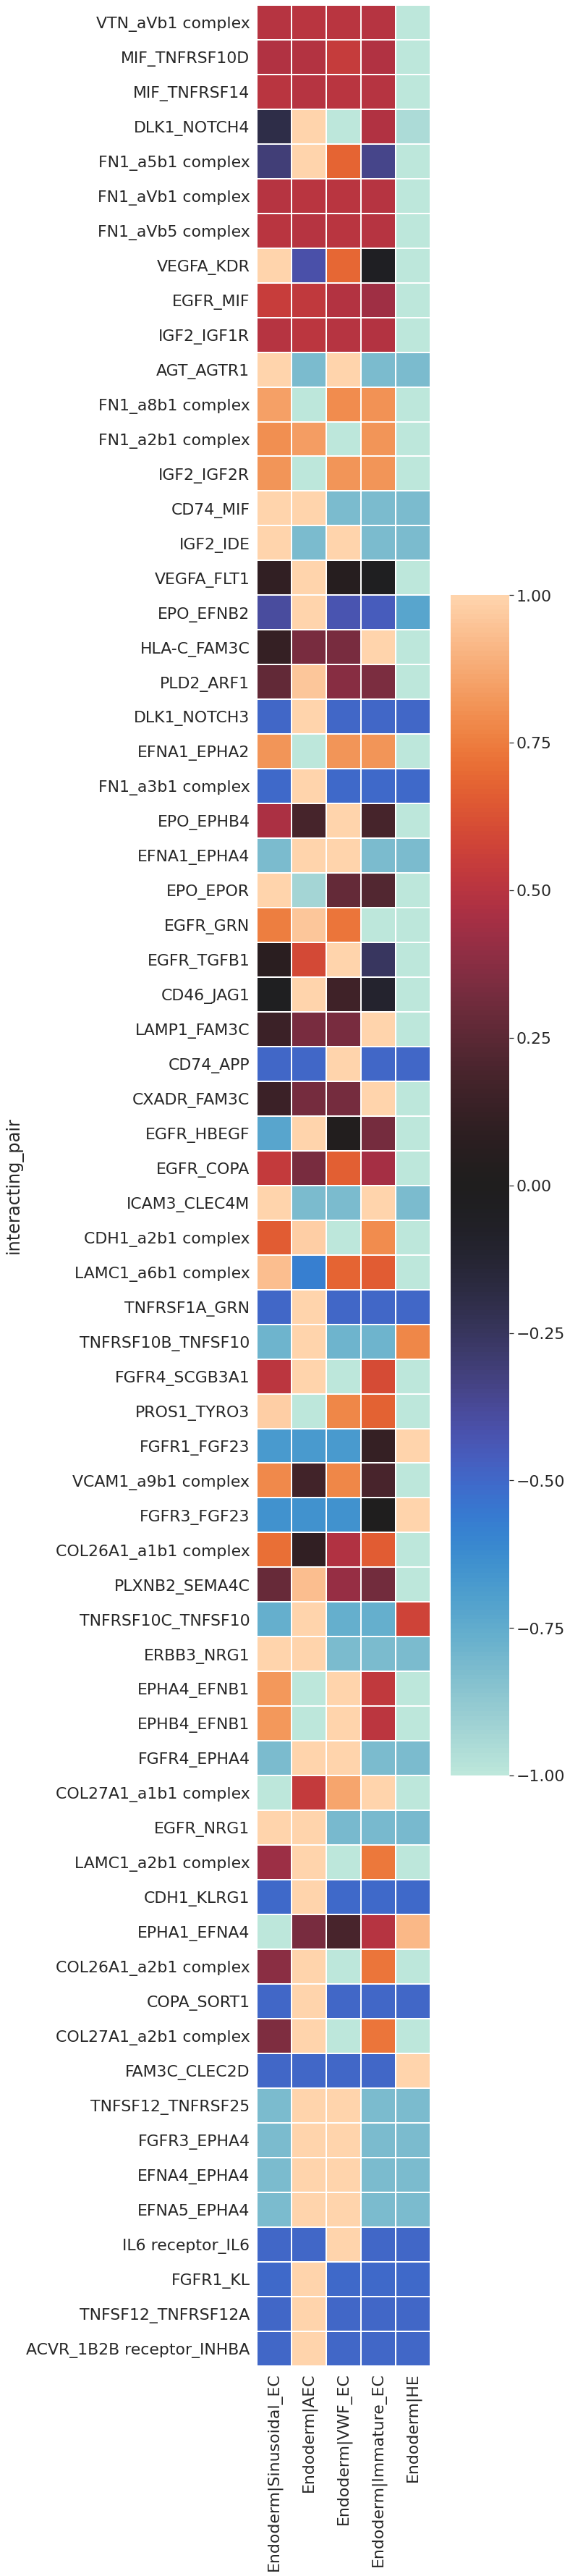

In [24]:
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Endoderm')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Endoderm')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp[list(ranking_col.index)]
# Remove 0 interacting rows
cpdb_tmp = cpdb_tmp.loc[(cpdb_tmp.sum(axis=1) != 0), (cpdb_tmp.sum(axis=0) != 0)]
cpdb_tmp =  pd.concat([cpdb_interaction[cpdb_metrics][cpdb_interaction.index.isin(cpdb_tmp.index)] ,cpdb_tmp], axis = 1)#add metrics back
# cpdb_tmp[cpdb_metrics] = cpdb_interaction[cpdb_metrics][cpdb_interaction.index.isin(cpdb_tmp.index)] #add metrics back
# Raning rows and reorder
ranking_row =  pd.DataFrame(cpdb_tmp[cpdb_tmp.columns[~cpdb_tmp.columns.isin(cpdb_metrics)]].sum(axis=1, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp.T[list(ranking_row.index)].T
cpdb_tmp_plot = cpdb_tmp.drop((cpdb_metrics[0:len(cpdb_metrics)]),axis = 1)

import scipy.stats as stats
cpdb_tmp_plot = cpdb_tmp_plot.T
for i in list(range(0,len(cpdb_tmp_plot.columns))):
    cpdb_tmp_plot.iloc[:,i] = stats.zscore(list(cpdb_tmp_plot.iloc[:,i]))
cpdb_tmp_plot = cpdb_tmp_plot.T
cpdb_tmp_plot[cpdb_metrics[0]] = cpdb_tmp[cpdb_metrics[0]]


cpdb_tmp_plot.index = cpdb_tmp_plot['interacting_pair']
cpdb_tmp_plot = cpdb_tmp_plot.drop(['interacting_pair'],axis = 1)
sns.heatmap(cpdb_tmp_plot,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

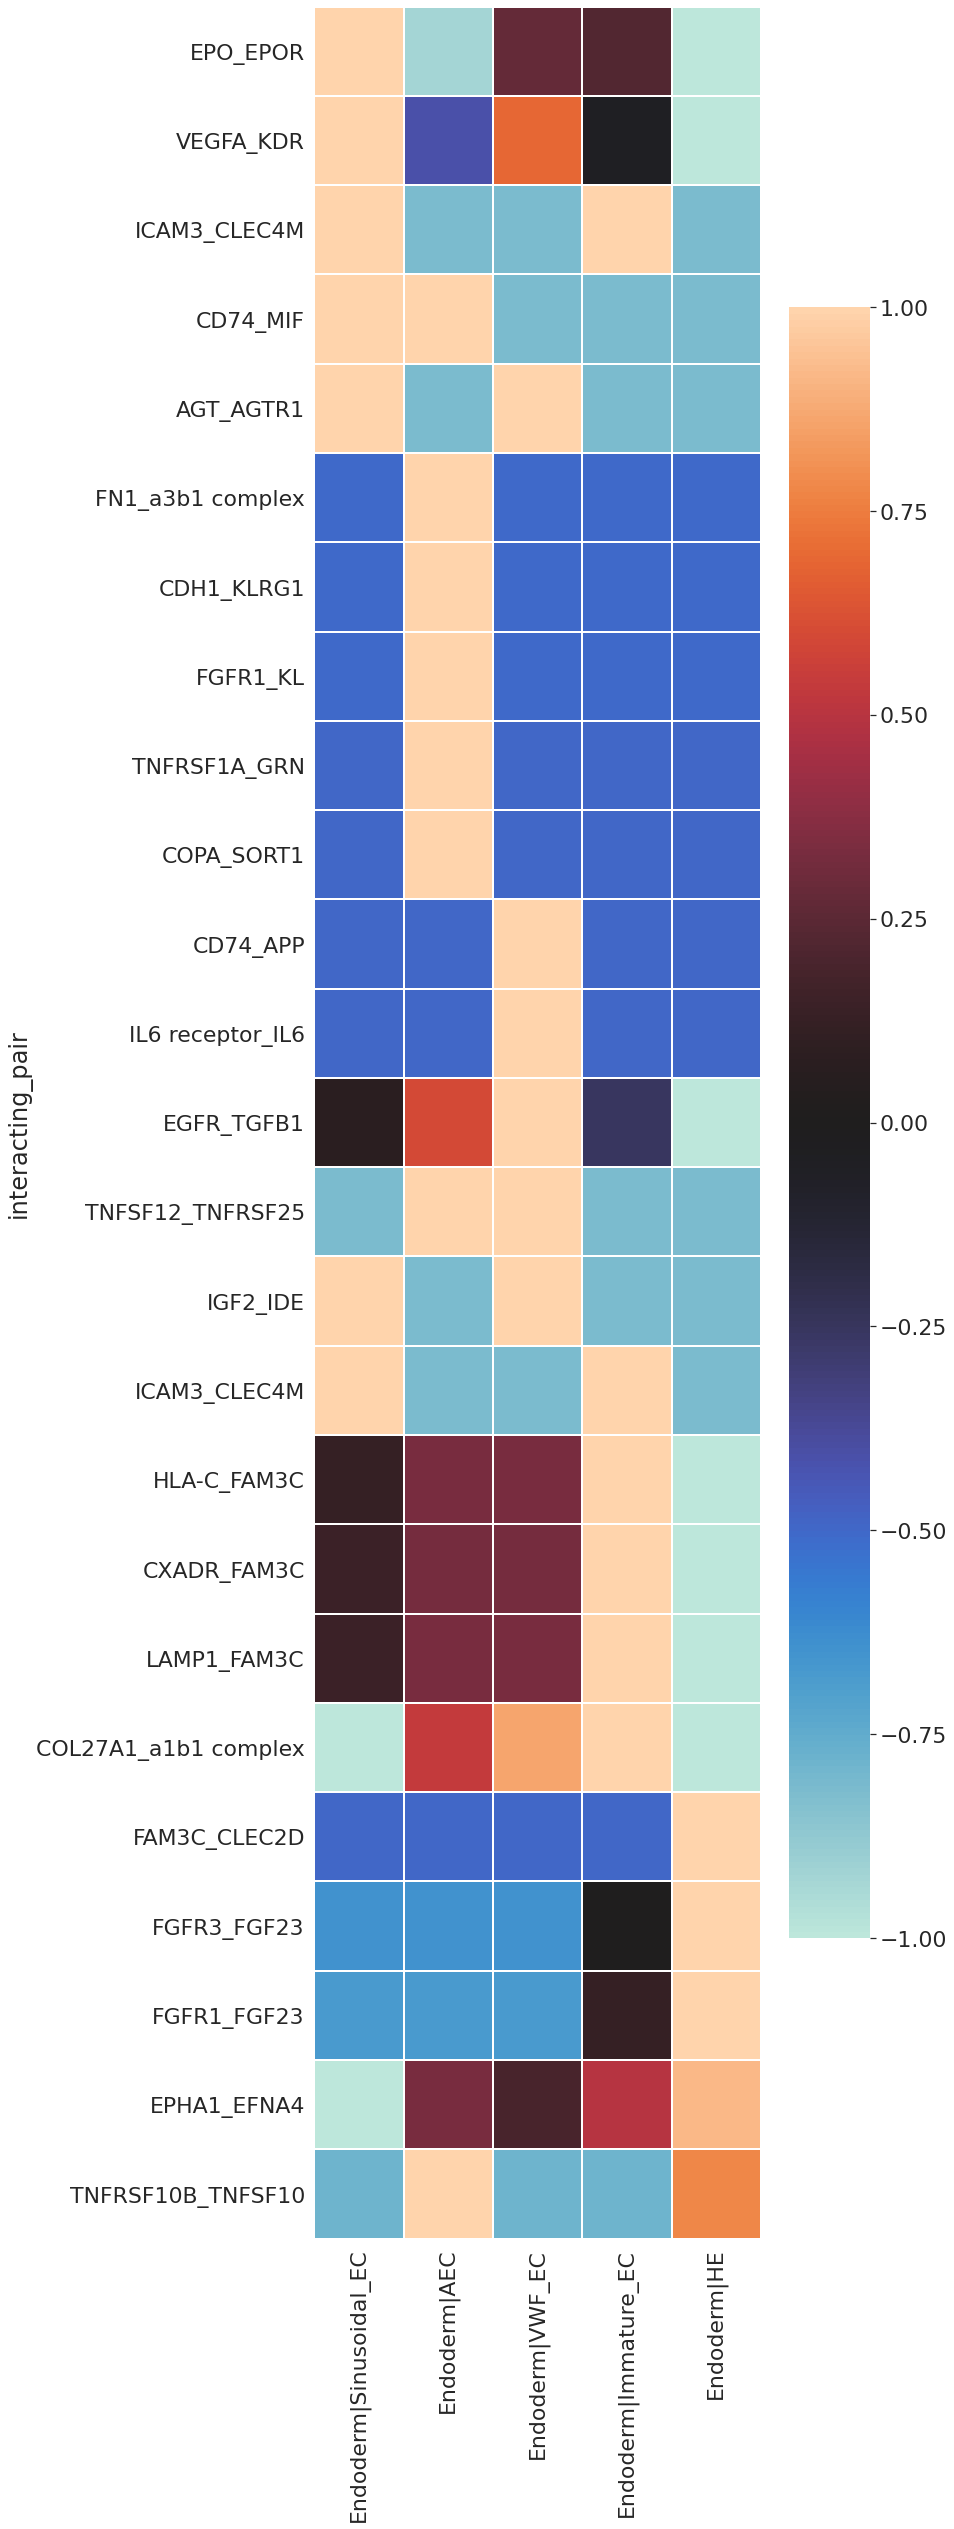

In [32]:
keep = []
for i in ranking_col.index:
    keep.extend(list(cpdb_tmp_plot[i].nlargest(5).index))
cpdb_tmp_plot_top = cpdb_tmp_plot.T[keep].T
fig = sns.heatmap(cpdb_tmp_plot_top,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})
fig = fig.get_figure()
fig.savefig(bbox_inches='tight',fname = 'top_Endoderm_EC_interactions.pdf')

In [36]:
cpdb_tmp_plot_top.columns

Index(['Endoderm|Sinusoidal_EC', 'Endoderm|AEC', 'Endoderm|VWF_EC',
       'Endoderm|Immature_EC', 'Endoderm|HE'],
      dtype='object')

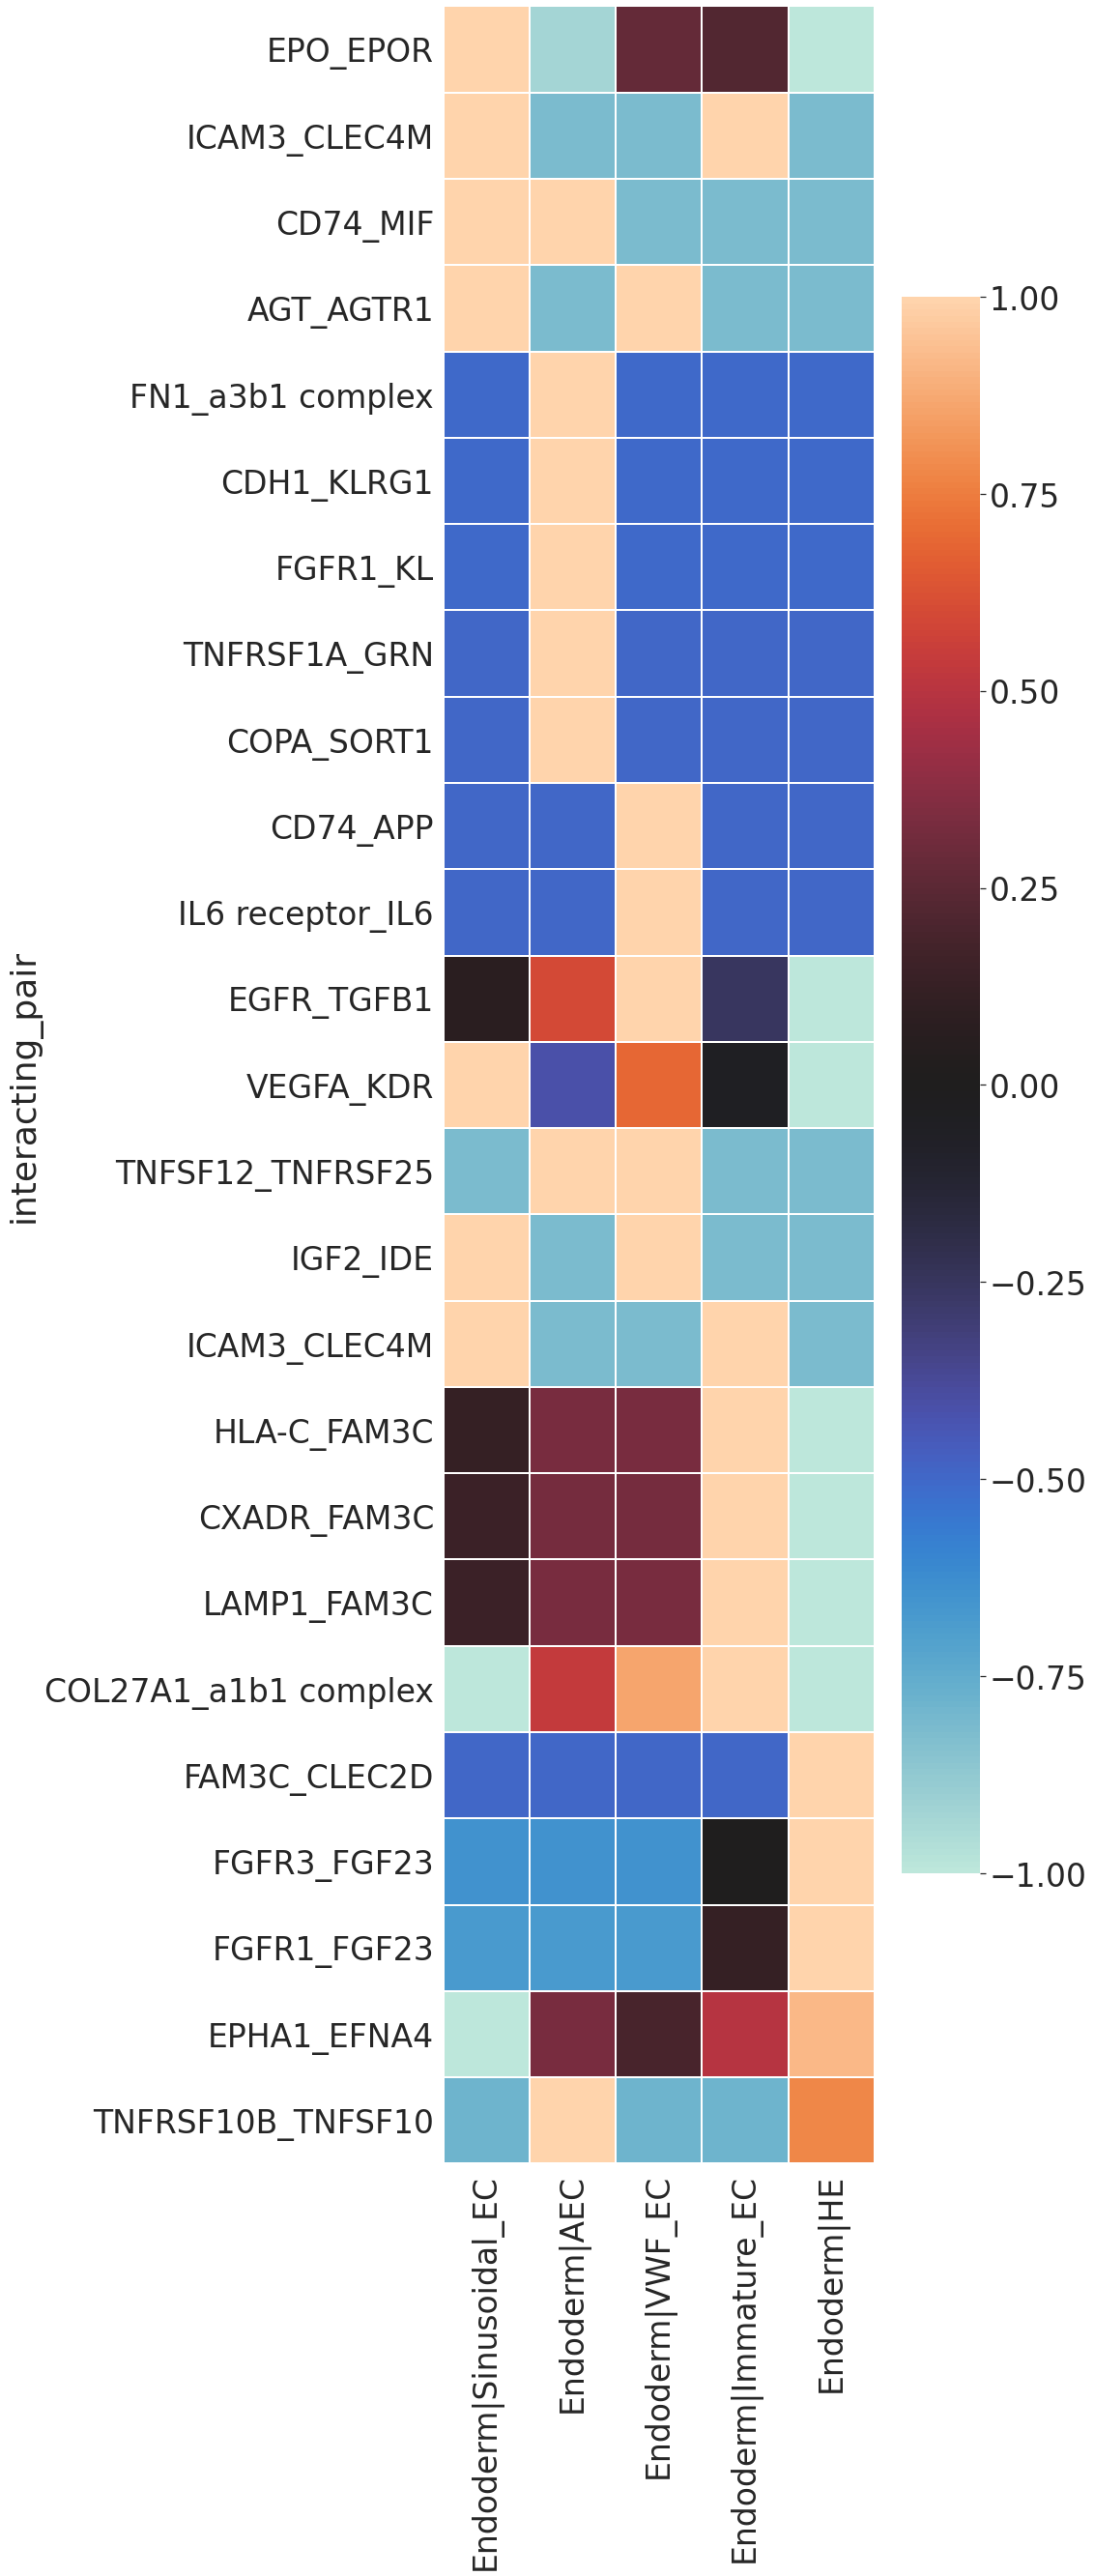

In [37]:
keep = [
 'EPO_EPOR',
 'ICAM3_CLEC4M',
 'CD74_MIF',
 'AGT_AGTR1',
 'FN1_a3b1 complex',
 'CDH1_KLRG1',
 'FGFR1_KL',
 'TNFRSF1A_GRN',
 'COPA_SORT1',
 'CD74_APP',
 'IL6 receptor_IL6',
 'EGFR_TGFB1',
 'VEGFA_KDR',
 'TNFSF12_TNFRSF25',
 'IGF2_IDE',
 'ICAM3_CLEC4M',
 'HLA-C_FAM3C',
 'CXADR_FAM3C',
 'LAMP1_FAM3C',
 'COL27A1_a1b1 complex',
 'FAM3C_CLEC2D',
 'FGFR3_FGF23',
 'FGFR1_FGF23',
 'EPHA1_EFNA4',
 'TNFRSF10B_TNFSF10']
cpdb_tmp_plot_top = cpdb_tmp_plot.T[keep].T
cpdb_tmp_plot_top = cpdb_tmp_plot_top[['Endoderm|Sinusoidal_EC', 'Endoderm|AEC', 'Endoderm|VWF_EC','Endoderm|Immature_EC', 'Endoderm|HE']]
sns.set(font_scale = 3)
fig = sns.heatmap(cpdb_tmp_plot_top,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})
fig = fig.get_figure()
fig.savefig(bbox_inches='tight',fname = 'top_microglia_EC_interactions.pdf')

In [40]:
keep = {}
for i in ranking_col.index:
#     keep[i] = list(cpdb_tmp[['gene_a']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str)) + list(cpdb_tmp[['gene_b']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str))
    keep[i] = list(cpdb_tmp[['gene_a']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(10).index))].iloc[:,0].astype(str)) 

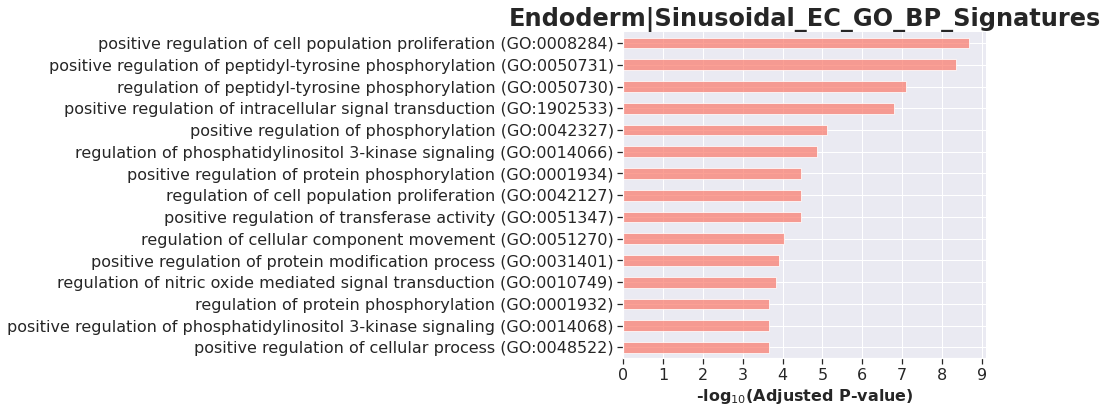

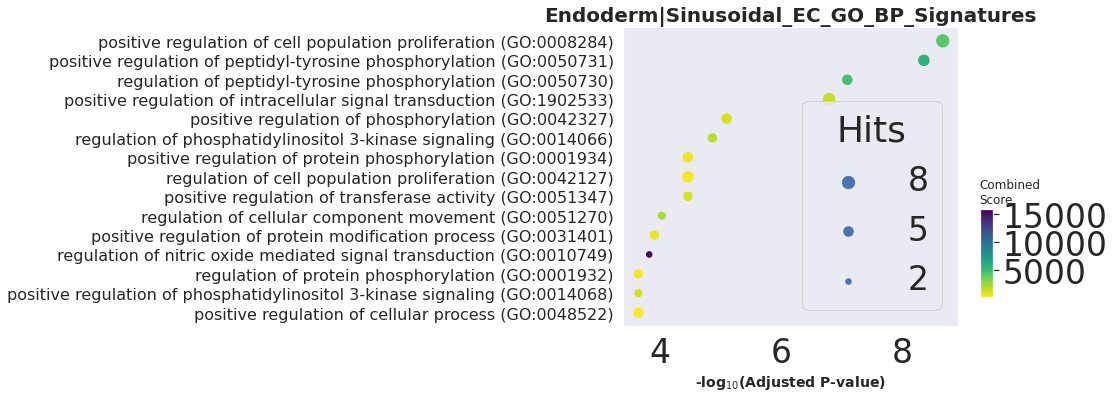

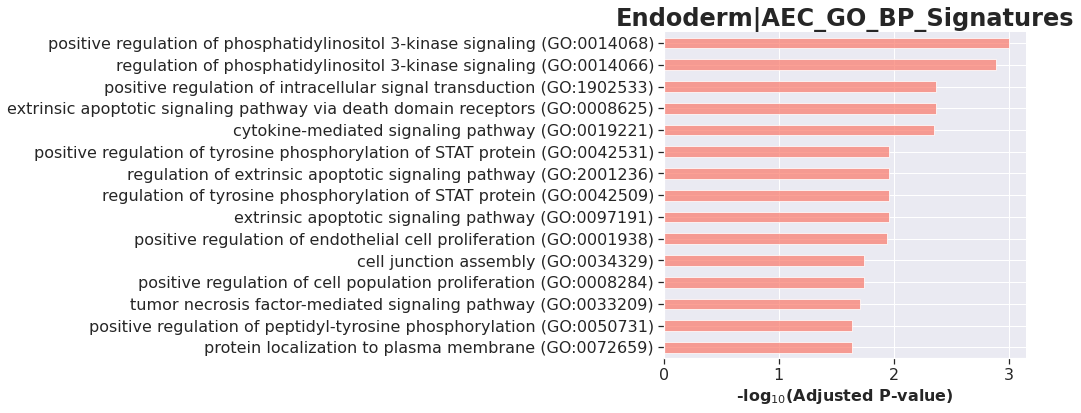

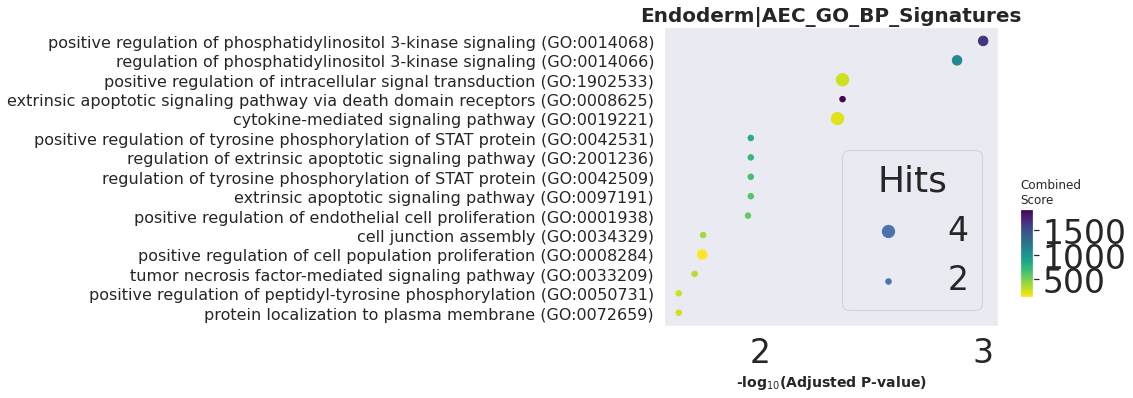

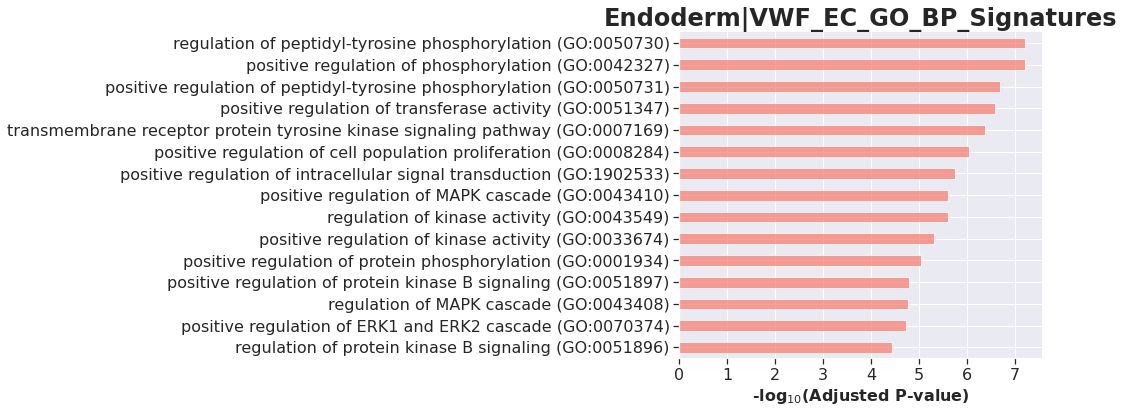

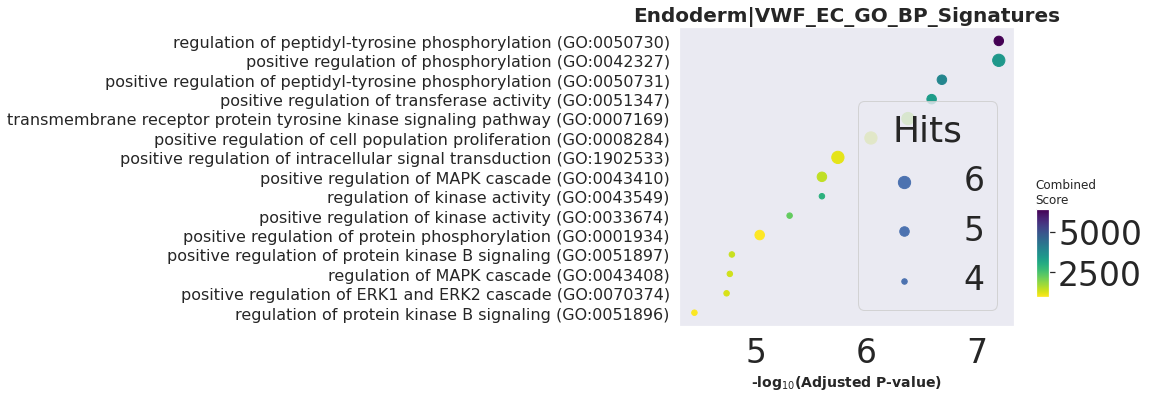

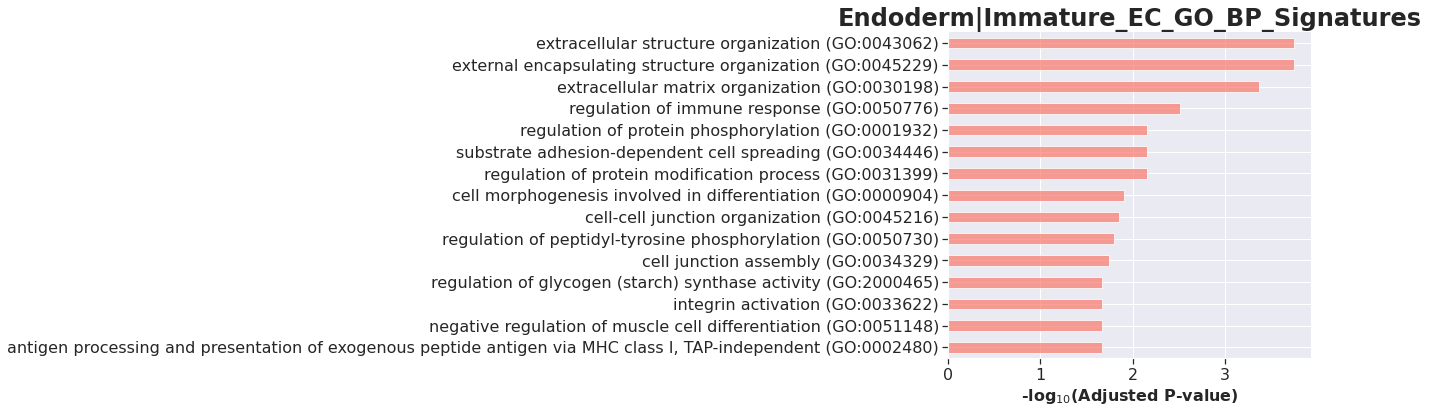

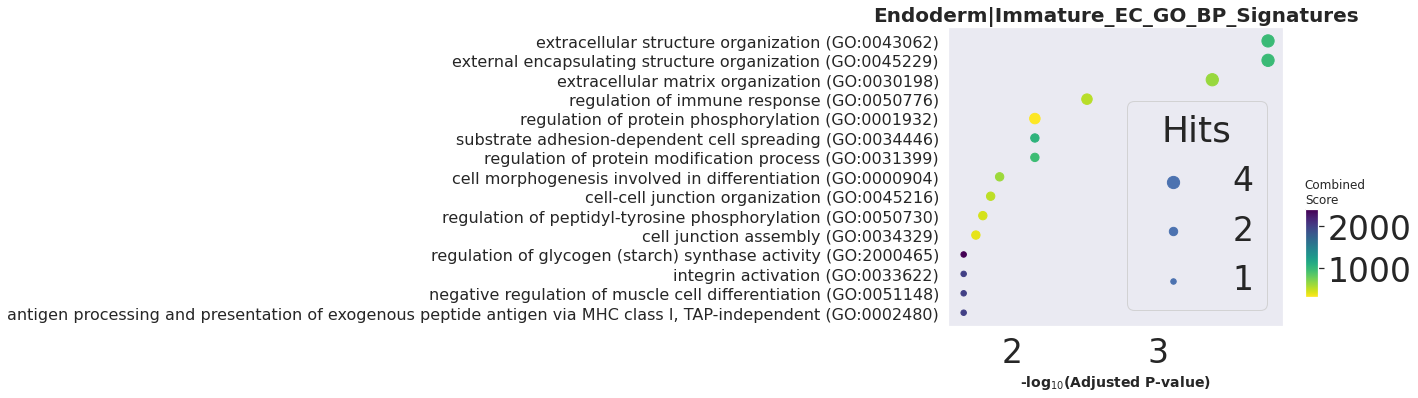

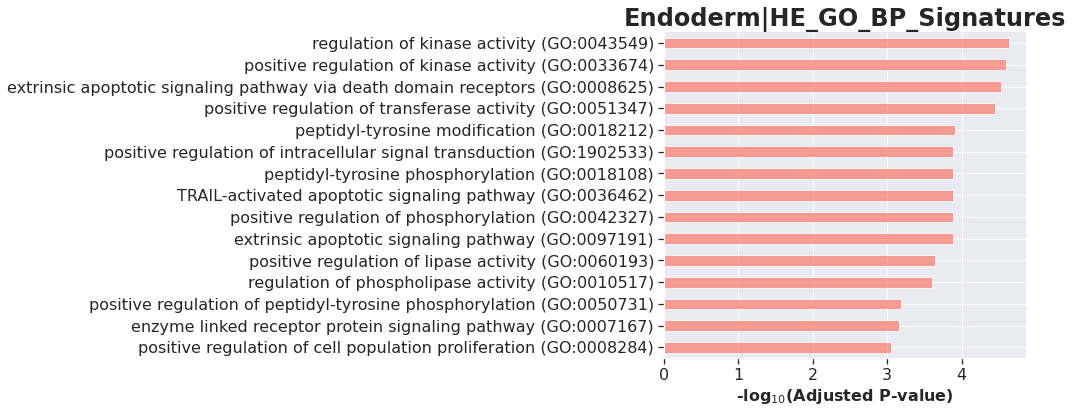

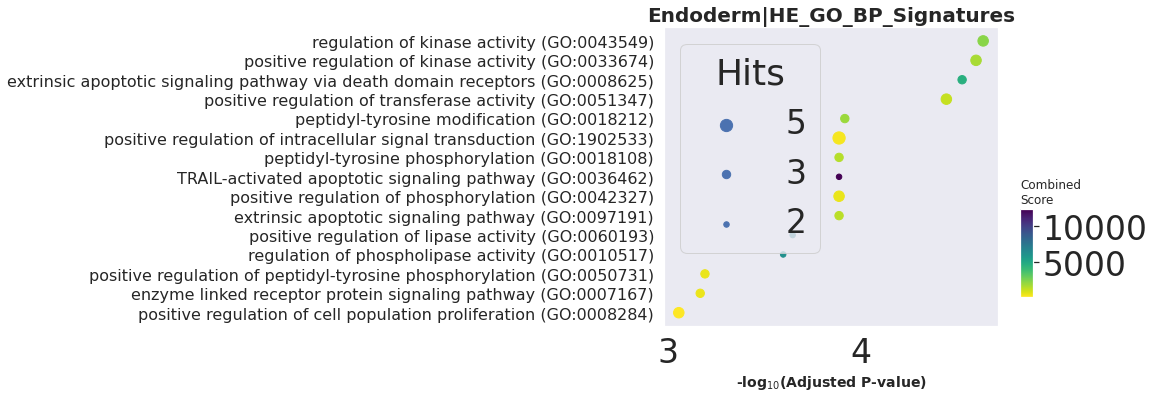

In [41]:
import gseapy
gene_set_names = gseapy.get_library_name(database='Human')

for i in keep.keys():
    #Available databases : 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' 
    import gseapy
    gene_set_names = gseapy.get_library_name(database='Human')
    glist = keep[i]
    glist = [x for x in glist if x != 'nan']
                                
    enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021' ,#'GO_Molecular_Function_2021', #''GO_Biological_Process_2021',
                     description='pathway',
                     cutoff = 0.05)
    enr_res.res2d.to_csv('./'+i+'_enr_res_score.csv')
    gseapy.barplot(enr_res.res2d,title=(i+ '_GO_BP_Signatures'),top_term=15)
    gseapy.dotplot(enr_res.res2d, title=(i+'_GO_BP_Signatures'),cmap='viridis_r',top_term=15)

# Q2 Which subsets of EC most communicate with Microglia?

In [73]:
rcParams['figure.figsize'] = 10,60

In [74]:
cpdb = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/cpdb_microglia_EC_communication/cpdb_out/significant_means.txt', delimiter = "\t",index_col=0)
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20211111_with_obsp.h5ad')

In [93]:
keep = [
#'Endoderm',
'Sinusoidal_EC',
'Immature_EC',
# 'Prolif_Sinusoidal_EC',
 'AEC',
 'HE',
# 'Macrophage',
#  'Monocyte',
  'Microglia',
#  'Pre_Macrophage',
 'VWF_EC',
#  'Prolif_AEC',
]

from itertools import product
combi = (pd.DataFrame(product(keep,keep)))
combi['combi'] = combi.iloc[:,0].astype(str) + "|" +combi.iloc[:,1].astype(str)
cpdb_metrics = ['interacting_pair',
 'partner_a',
 'partner_b',
 'gene_a',
 'gene_b',
 'secreted',
 'receptor_a',
 'receptor_b',
 'annotation_strategy',
 'is_integrin',
 'rank',]
cpdb_interaction = cpdb[cpdb_metrics+list(combi['combi'])]

<ipython-input-94-536a17c584f7>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Microglia')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Microglia')])].fillna(0)


<AxesSubplot:ylabel='interacting_pair'>

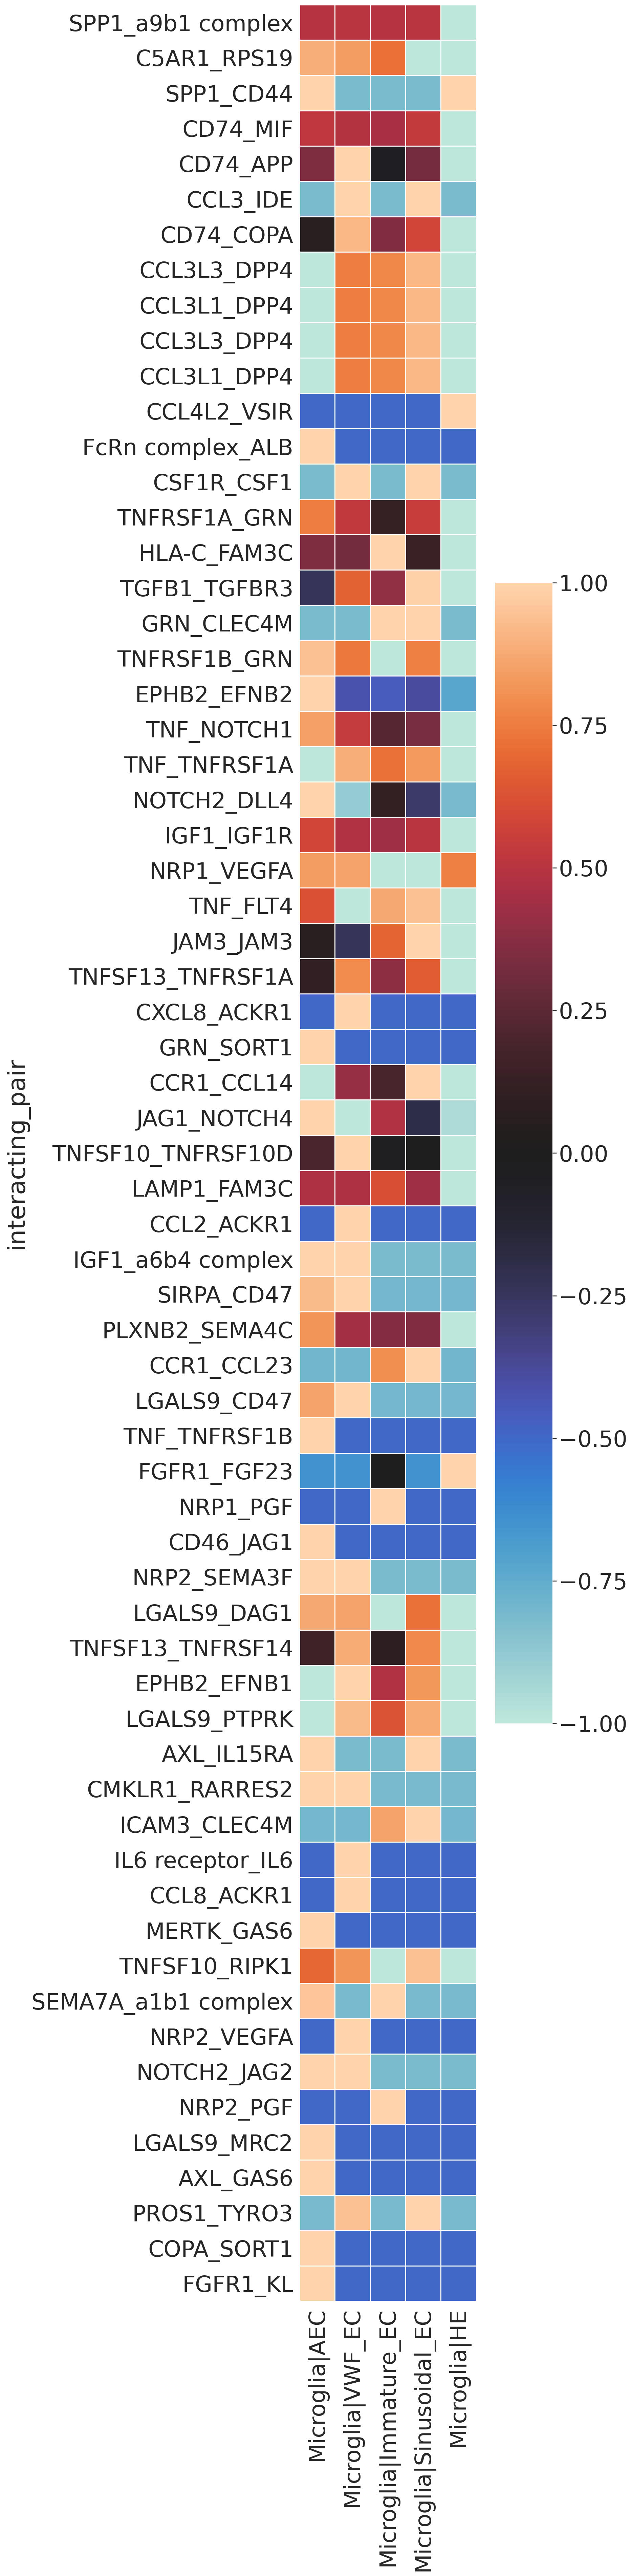

In [94]:
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Microglia')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Microglia')])].fillna(0)
#cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.contains('Microglia')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp[list(ranking_col.index)]
# Remove 0 interacting rows
cpdb_tmp = cpdb_tmp.loc[(cpdb_tmp.sum(axis=1) != 0), (cpdb_tmp.sum(axis=0) != 0)]
cpdb_tmp =  pd.concat([cpdb_interaction[cpdb_metrics][cpdb_interaction.index.isin(cpdb_tmp.index)] ,cpdb_tmp], axis = 1)#add metrics back
# cpdb_tmp[cpdb_metrics] = cpdb_interaction[cpdb_metrics][cpdb_interaction.index.isin(cpdb_tmp.index)] #add metrics back
# Raning rows and reorder
ranking_row =  pd.DataFrame(cpdb_tmp[cpdb_tmp.columns[~cpdb_tmp.columns.isin(cpdb_metrics)]].sum(axis=1, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp.T[list(ranking_row.index)].T
cpdb_tmp_plot = cpdb_tmp.drop((cpdb_metrics[0:len(cpdb_metrics)]),axis = 1)

import scipy.stats as stats
cpdb_tmp_plot = cpdb_tmp_plot.T
for i in list(range(0,len(cpdb_tmp_plot.columns))):
    cpdb_tmp_plot.iloc[:,i] = stats.zscore(list(cpdb_tmp_plot.iloc[:,i]))
cpdb_tmp_plot = cpdb_tmp_plot.T
cpdb_tmp_plot[cpdb_metrics[0]] = cpdb_tmp[cpdb_metrics[0]]


cpdb_tmp_plot.index = cpdb_tmp_plot['interacting_pair']
cpdb_tmp_plot = cpdb_tmp_plot.drop(['interacting_pair'],axis = 1)
sns.heatmap(cpdb_tmp_plot,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

# Get top ranking Interactions between Microglia and Endothelium

<AxesSubplot:ylabel='interacting_pair'>

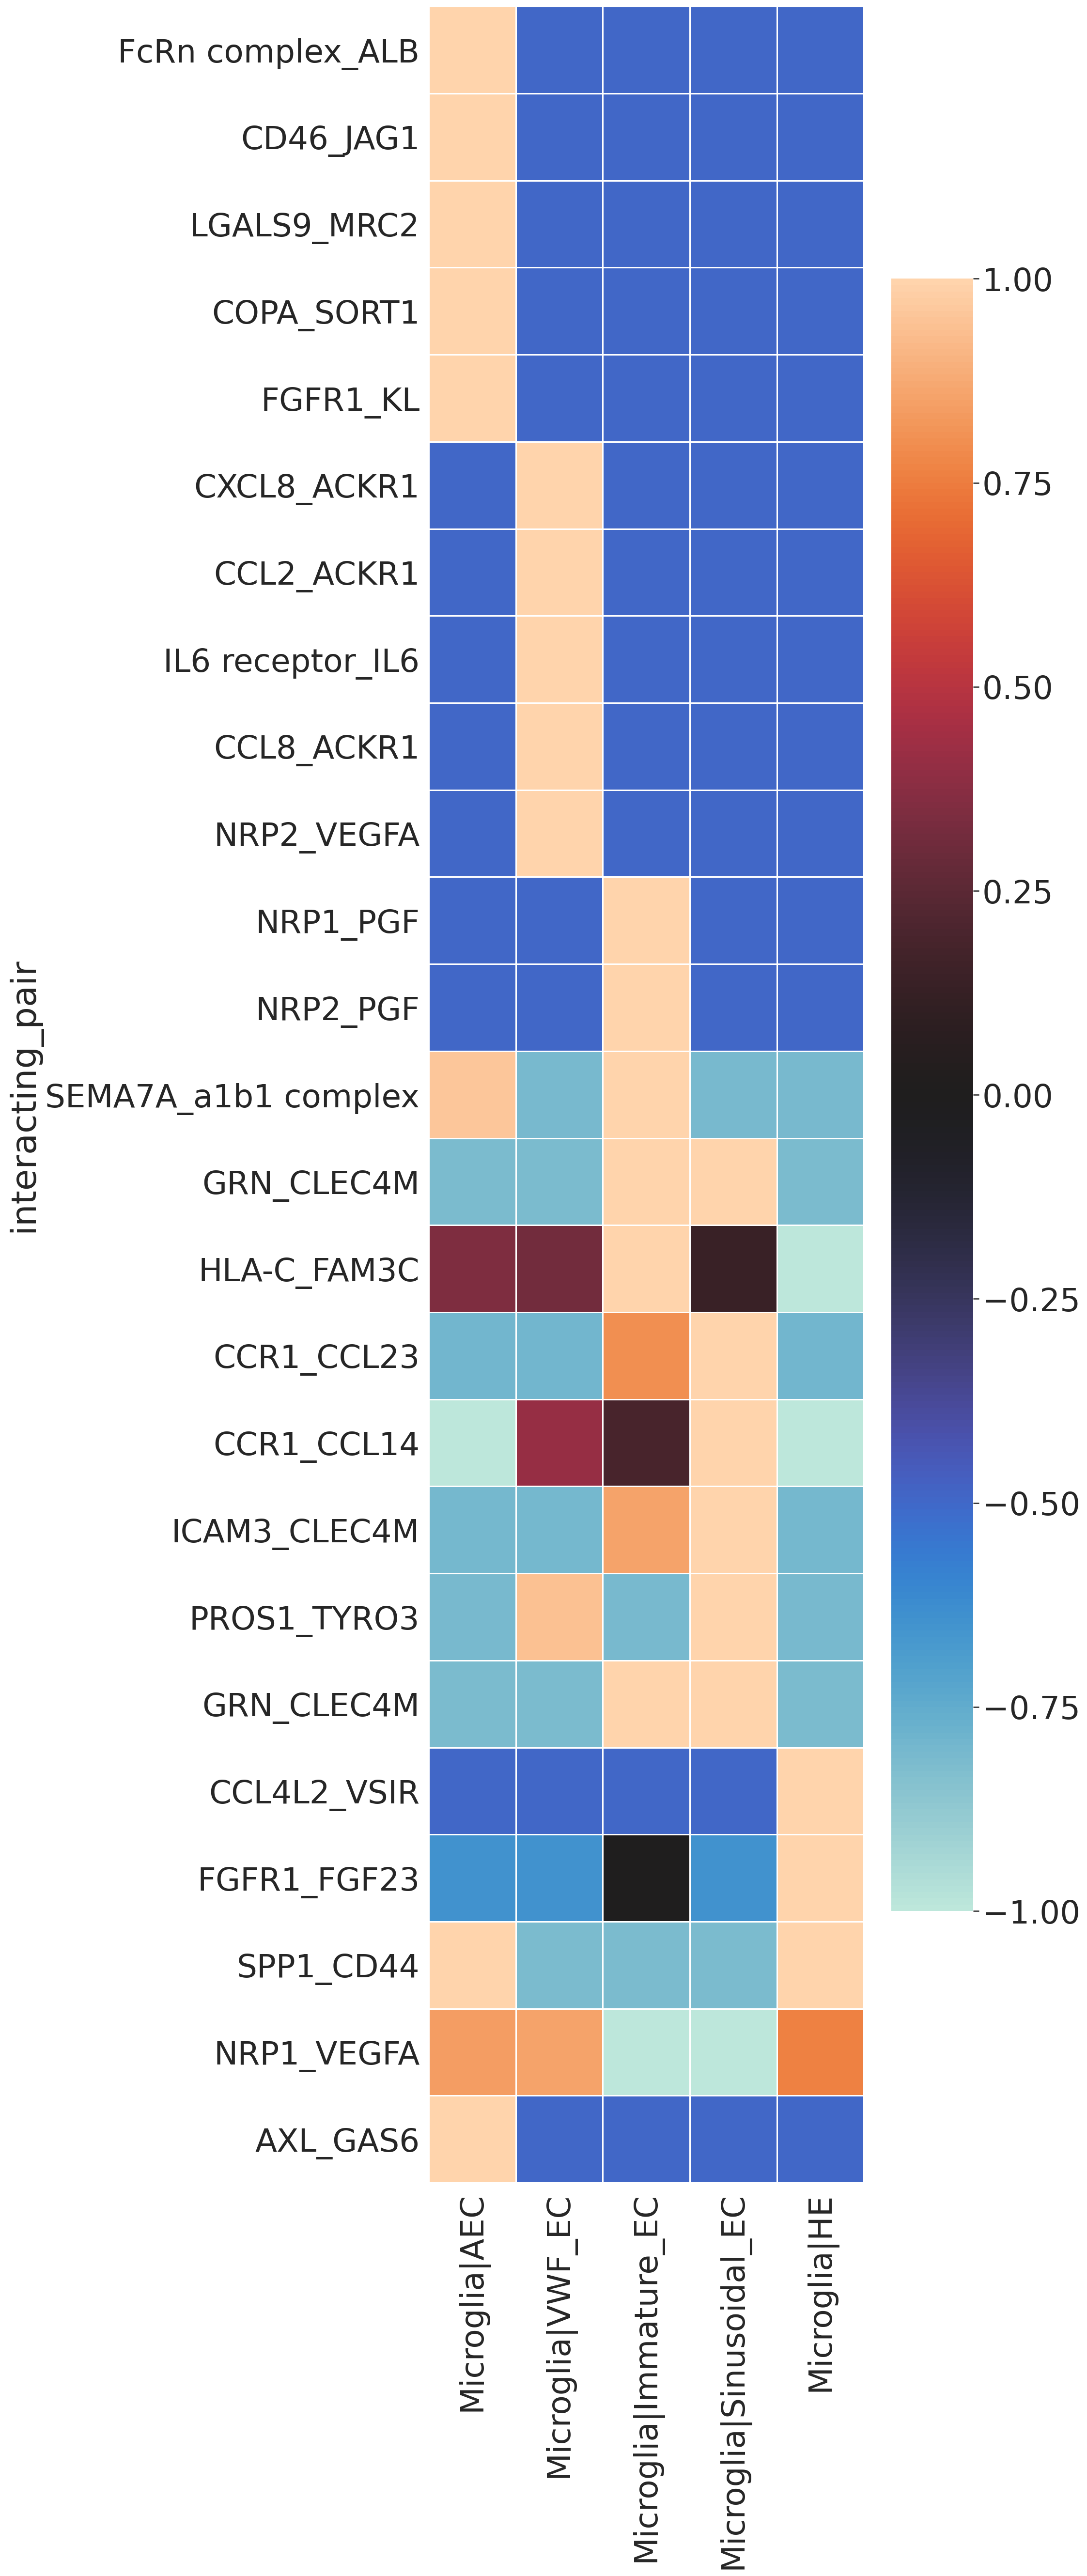

In [95]:
keep = []
for i in ranking_col.index:
    keep.extend(list(cpdb_tmp_plot[i].nlargest(5).index))
cpdb_tmp_plot_top = cpdb_tmp_plot.T[keep].T
sns.heatmap(cpdb_tmp_plot_top,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

In [96]:
[cpdb_tmp_plot_top.columns]

[Index(['Microglia|AEC', 'Microglia|VWF_EC', 'Microglia|Immature_EC',
        'Microglia|Sinusoidal_EC', 'Microglia|HE'],
       dtype='object')]

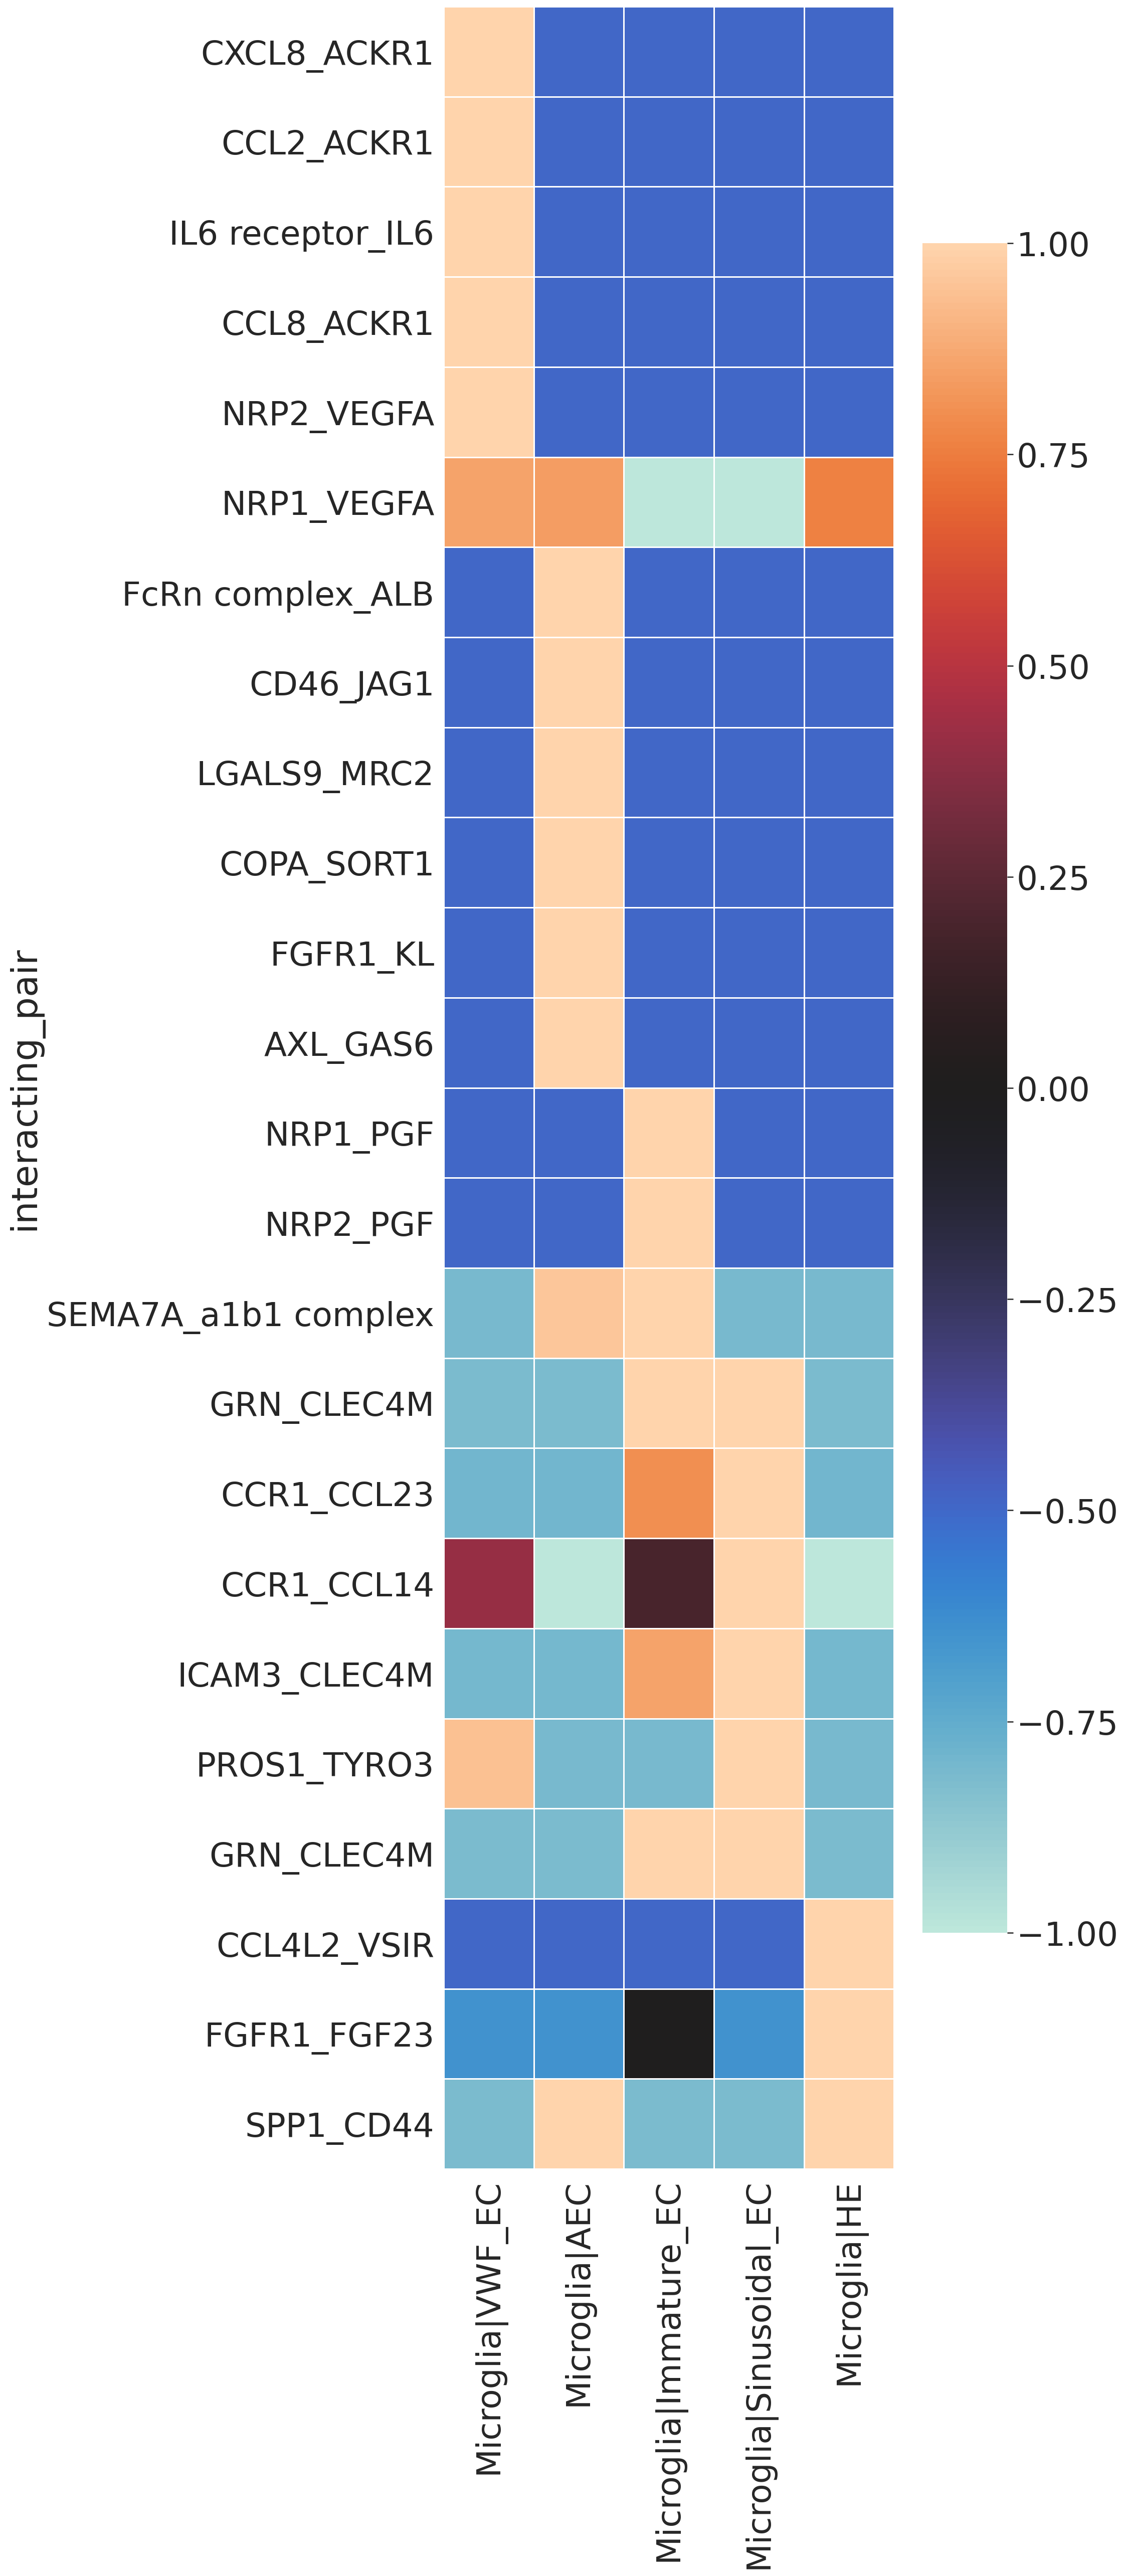

In [97]:
keep = [
 'CXCL8_ACKR1',
 'CCL2_ACKR1',
 'IL6 receptor_IL6',
 'CCL8_ACKR1',
 'NRP2_VEGFA',
   'NRP1_VEGFA',  
'FcRn complex_ALB',
 'CD46_JAG1',
 'LGALS9_MRC2',
 'COPA_SORT1',
 'FGFR1_KL',
 'AXL_GAS6',

 'NRP1_PGF',
 'NRP2_PGF',
 'SEMA7A_a1b1 complex',
 'GRN_CLEC4M',
 'CCR1_CCL23',
 'CCR1_CCL14',
 'ICAM3_CLEC4M',
 'PROS1_TYRO3',
 'GRN_CLEC4M',
 'CCL4L2_VSIR',
 'FGFR1_FGF23',
 'SPP1_CD44',]
cpdb_tmp_plot_top = cpdb_tmp_plot.T[keep].T
cpdb_tmp_plot_top = cpdb_tmp_plot_top[['Microglia|VWF_EC','Microglia|AEC', 'Microglia|Immature_EC','Microglia|Sinusoidal_EC', 'Microglia|HE']]
sns.set(font_scale = 3)
fig = sns.heatmap(cpdb_tmp_plot_top,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})
fig = fig.get_figure()
fig.savefig(bbox_inches='tight',fname = 'top_microglia_EC_interactions.pdf')

# Create GSEA ranking for each interaction set

In [98]:
ranking_col

0
Microglia|AEC            109.245
Microglia|VWF_EC          97.255
Microglia|Immature_EC     76.515
Microglia|Sinusoidal_EC   72.786
Microglia|HE              38.081

In [99]:
keep = {}
for i in ranking_col.index:
#     keep[i] = list(cpdb_tmp[['gene_a']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str)) + list(cpdb_tmp[['gene_b']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str))
    keep[i] = list(cpdb_tmp[['gene_a']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str)) 

In [ ]:
117,134

In [167]:
ec = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/cpdb_microglia_EC_communication/Microglia|VWF_EC_enr_res_score.csv',index_col=0)

In [168]:
ec['Overlap']

0        3/56
1        3/60
2        3/70
3        3/73
4        3/77
        ...  
158     1/496
159     1/566
160     1/764
161    1/1025
162    1/1079
Name: Overlap, Length: 163, dtype: object

In [169]:
list(ec.iloc[118:134]['Term'])
keep_gs = ['regulation of endothelial cell migration (GO:0010594)',
 'regulation of endothelial cell proliferation (GO:0001936)',
 'calcium-mediated signaling (GO:0019722)',
 'positive regulation of vasculature development (GO:1904018)',
 'positive regulation of angiogenesis (GO:0045766)']
ec = ec[ec['Term'].isin(keep_gs)]

In [170]:
ec

Gene_set  \
118  GO_Biological_Process_2021   
121  GO_Biological_Process_2021   
126  GO_Biological_Process_2021   
127  GO_Biological_Process_2021   
133  GO_Biological_Process_2021   

                                                  Term Overlap   P-value  \
118  regulation of endothelial cell migration (GO:0...    1/89  0.017683   
121  regulation of endothelial cell proliferation (...    1/92  0.018275   
126            calcium-mediated signaling (GO:0019722)   1/102  0.020246   
127  positive regulation of vasculature development...   1/102  0.020246   
133   positive regulation of angiogenesis (GO:0045766)   1/116  0.023000   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
118          0.024019            0                     0   75.409091   
121          0.024416            0                     0   72.912088   
126          0.025782            0                     0   65.660066   
127          0.025782            0                     0   65.660066   
133          0.027978            0                     0   57.626087   

     Combined Score  Genes  
118      304.288334   NRP2  
121      291.811721   NRP2  
126      256.061564  CXCL8  
127      256.061564  CXCL8  
133      217.379424  CXCL8

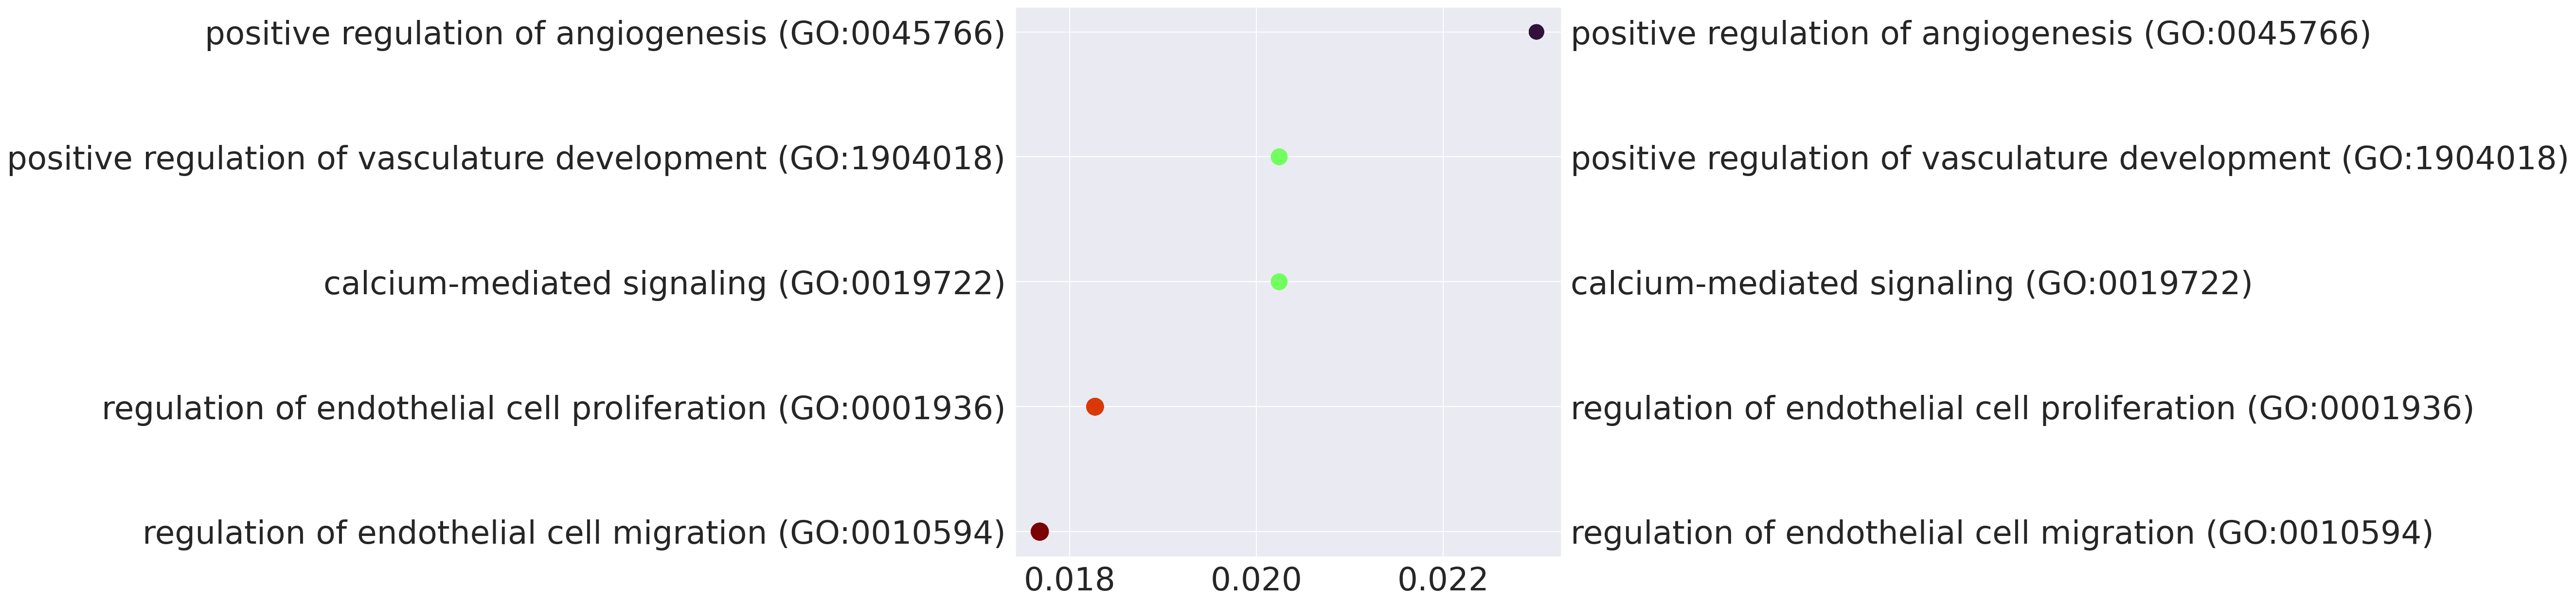

In [171]:
rcParams['figure.figsize'] = 10,10
for i in ec.index:
    y = np.array(ec['Term'])
    x = np.array(ec['P-value'])
    plt.scatter(x, y,s =ec['Combined Score'],c =ec['Combined Score'], cmap='turbo' )
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.show()

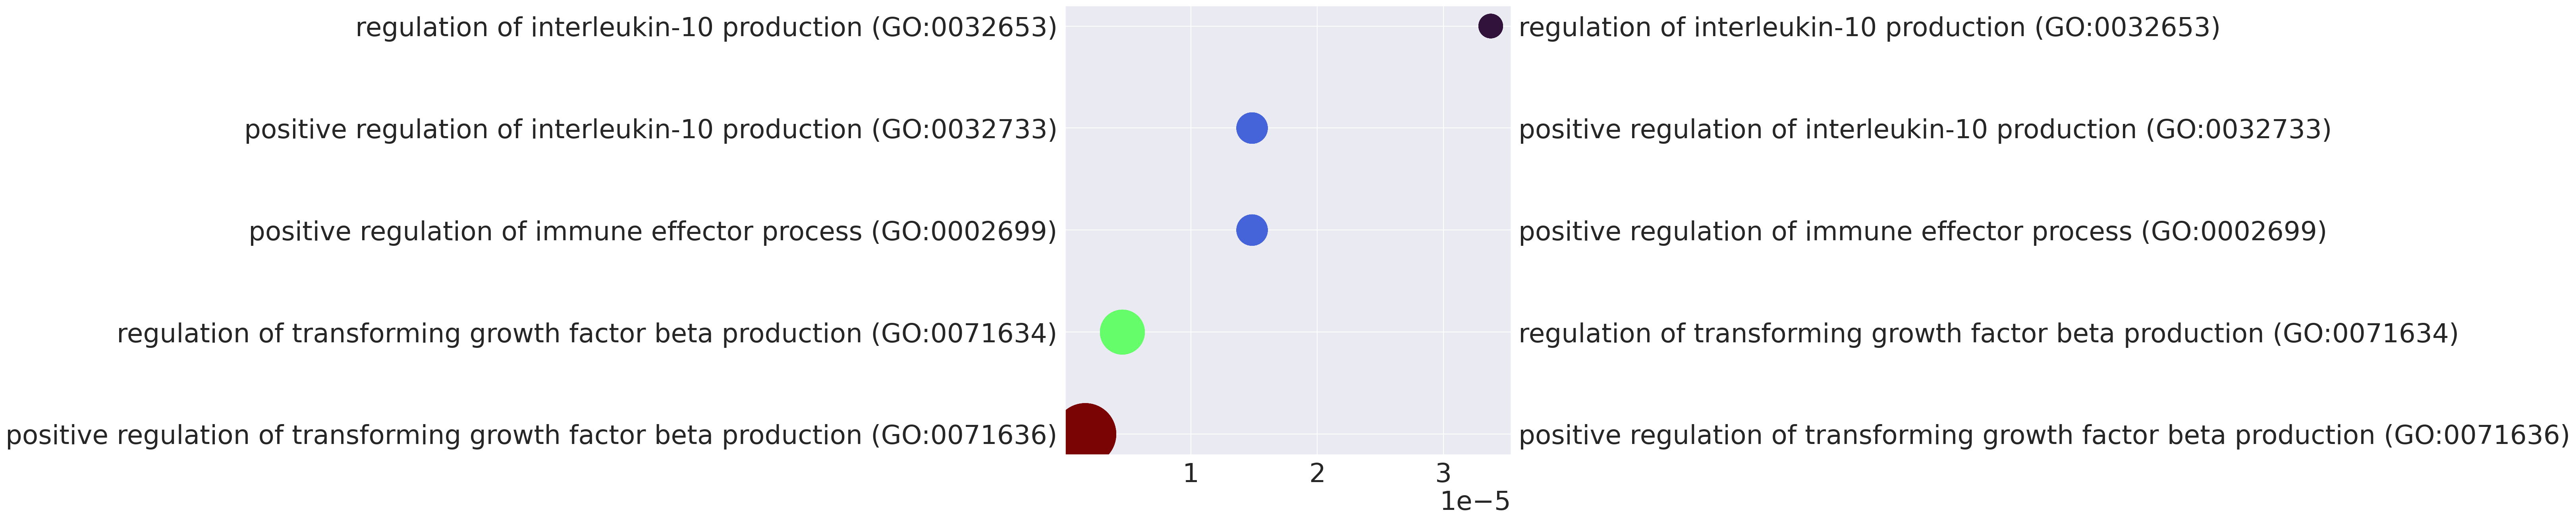

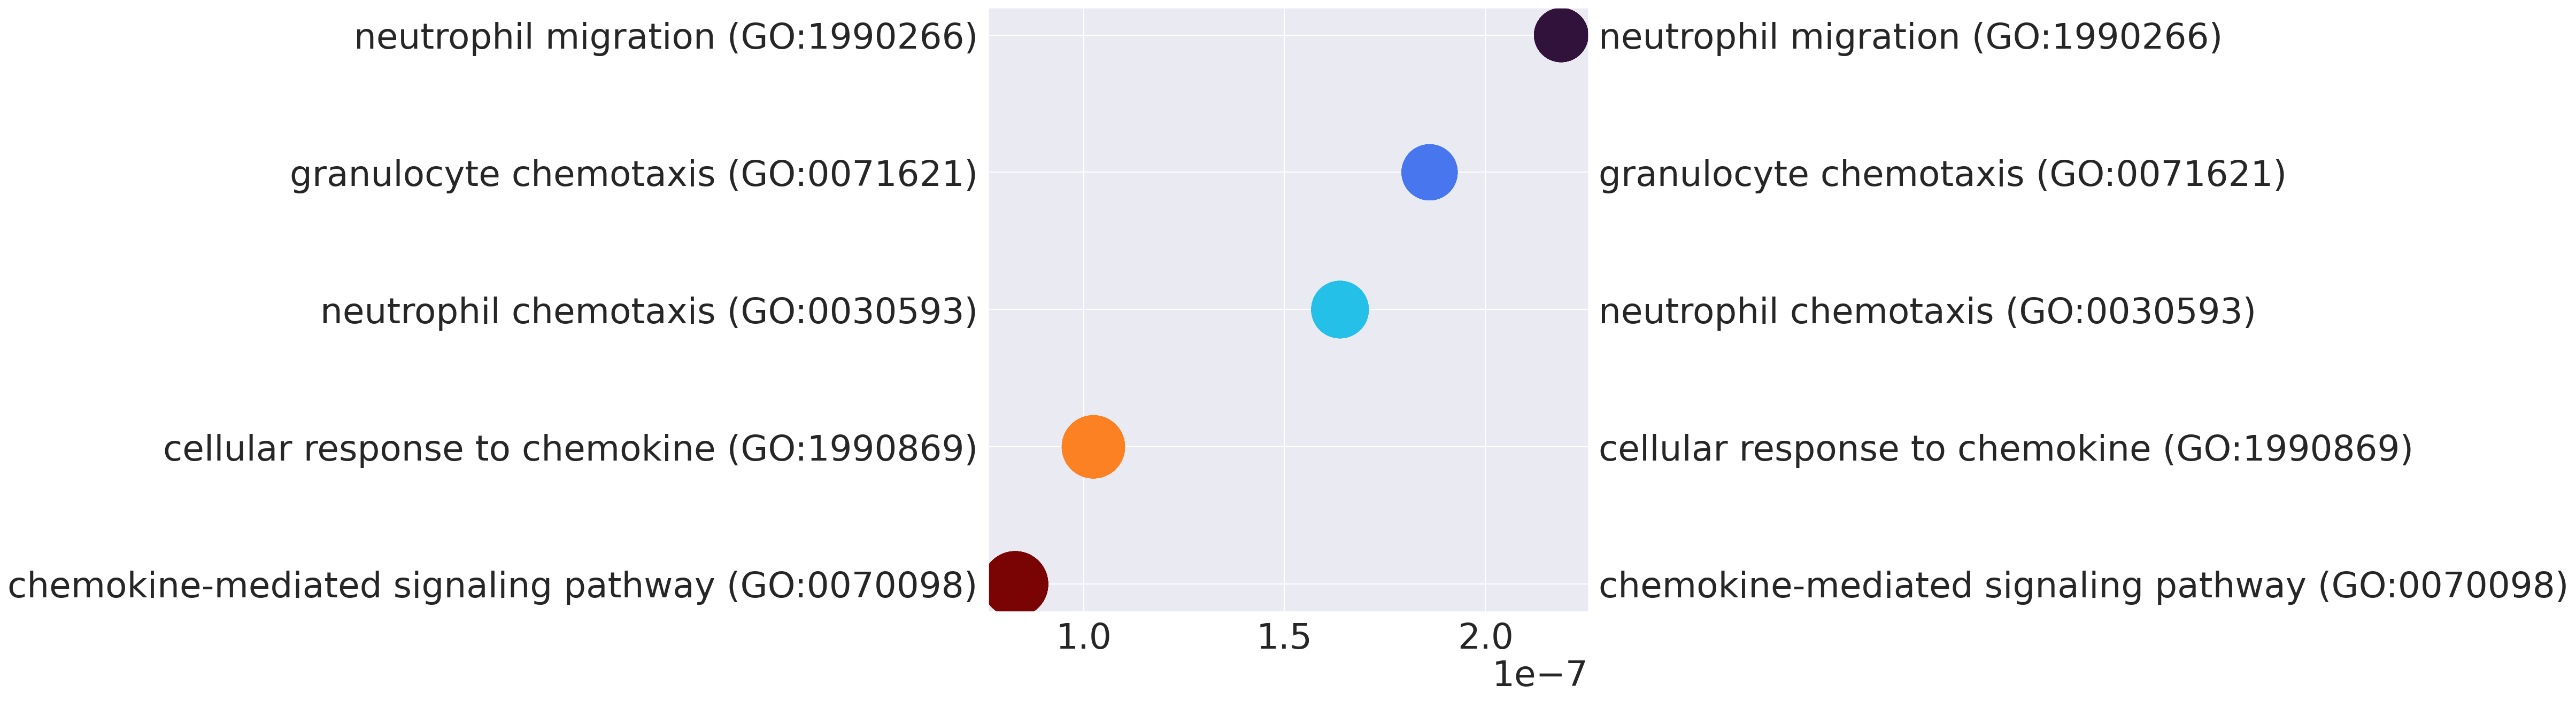

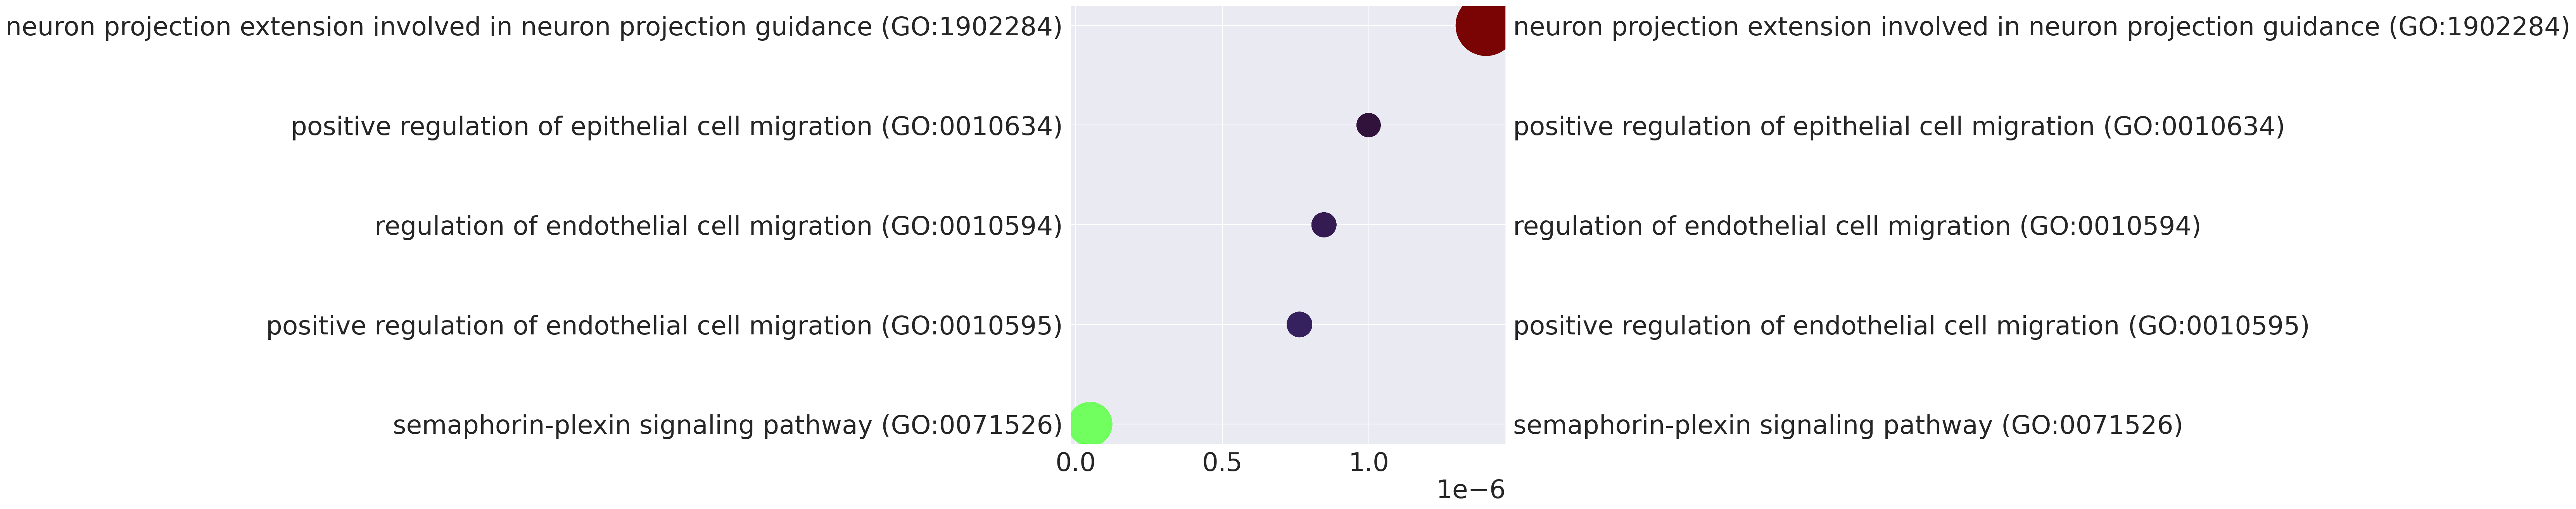

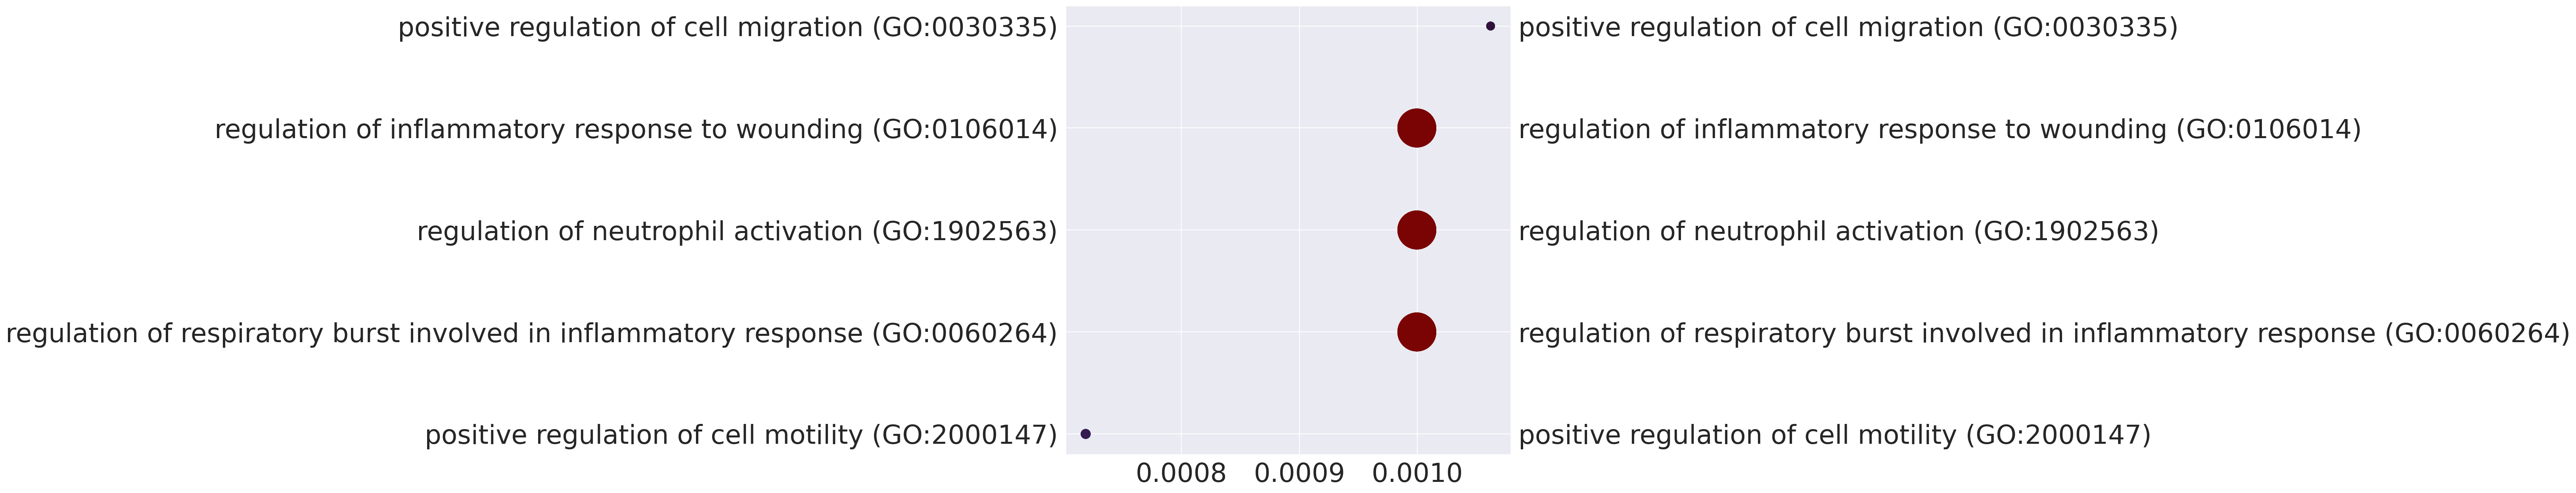

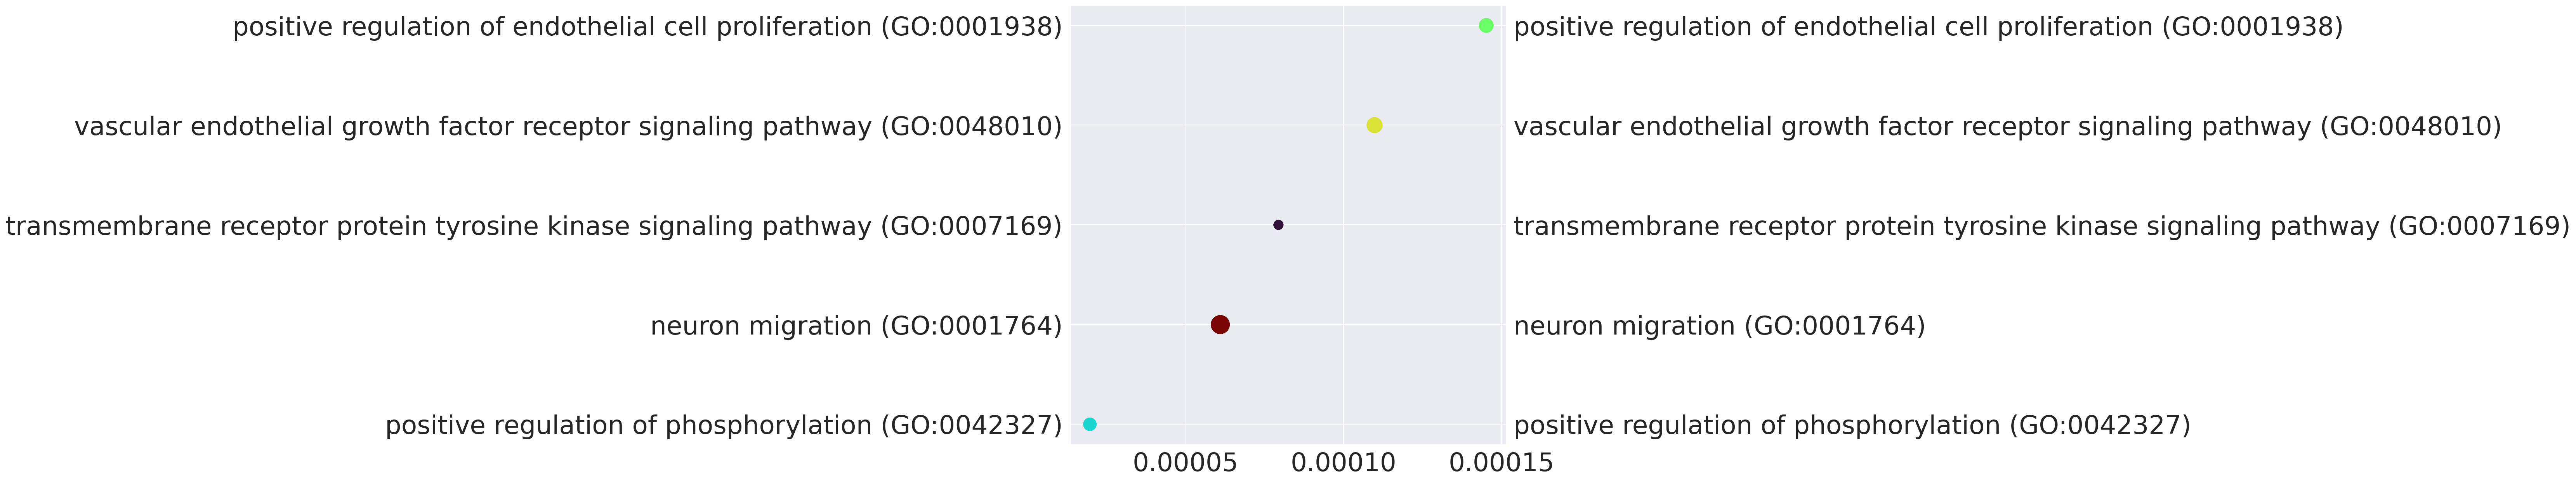

In [164]:
import gseapy
gene_set_names = gseapy.get_library_name(database='Human')

for i in keep.keys():
    #Available databases : 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' 
    import gseapy
    gene_set_names = gseapy.get_library_name(database='Human')
    glist = keep[i]
    glist = [x for x in glist if x != 'nan']
                                
    enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021' ,#'GO_Molecular_Function_2021', #''GO_Biological_Process_2021',
                     description='pathway',
                     cutoff = 0.1)
    enr_res.res2d.to_csv('./'+i+'_enr_res_score.csv')
#     gseapy.barplot(enr_res.res2d,title=(i+ '_GO_BP_Signatures'),top_term=5,color='blue')
#     gseapy.dotplot(enr_res.res2d, title=(i+'_GO_BP_Signatures'),cmap='viridis_r',legend=False,top_term=5)
    rcParams['figure.figsize'] = 10,10
    
    ec = enr_res.res2d.head(5)
    for i in ec.index:
        y = np.array(ec['Term'])
        x = np.array(ec['P-value'])
        plt.scatter(x, y,s =ec['Combined Score']/5,c =ec['Combined Score'], cmap='turbo' )
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
    plt.show()

<ipython-input-82-52ecd6bbab70>:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Microglia')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Microglia')])].fillna(0)


<AxesSubplot:>

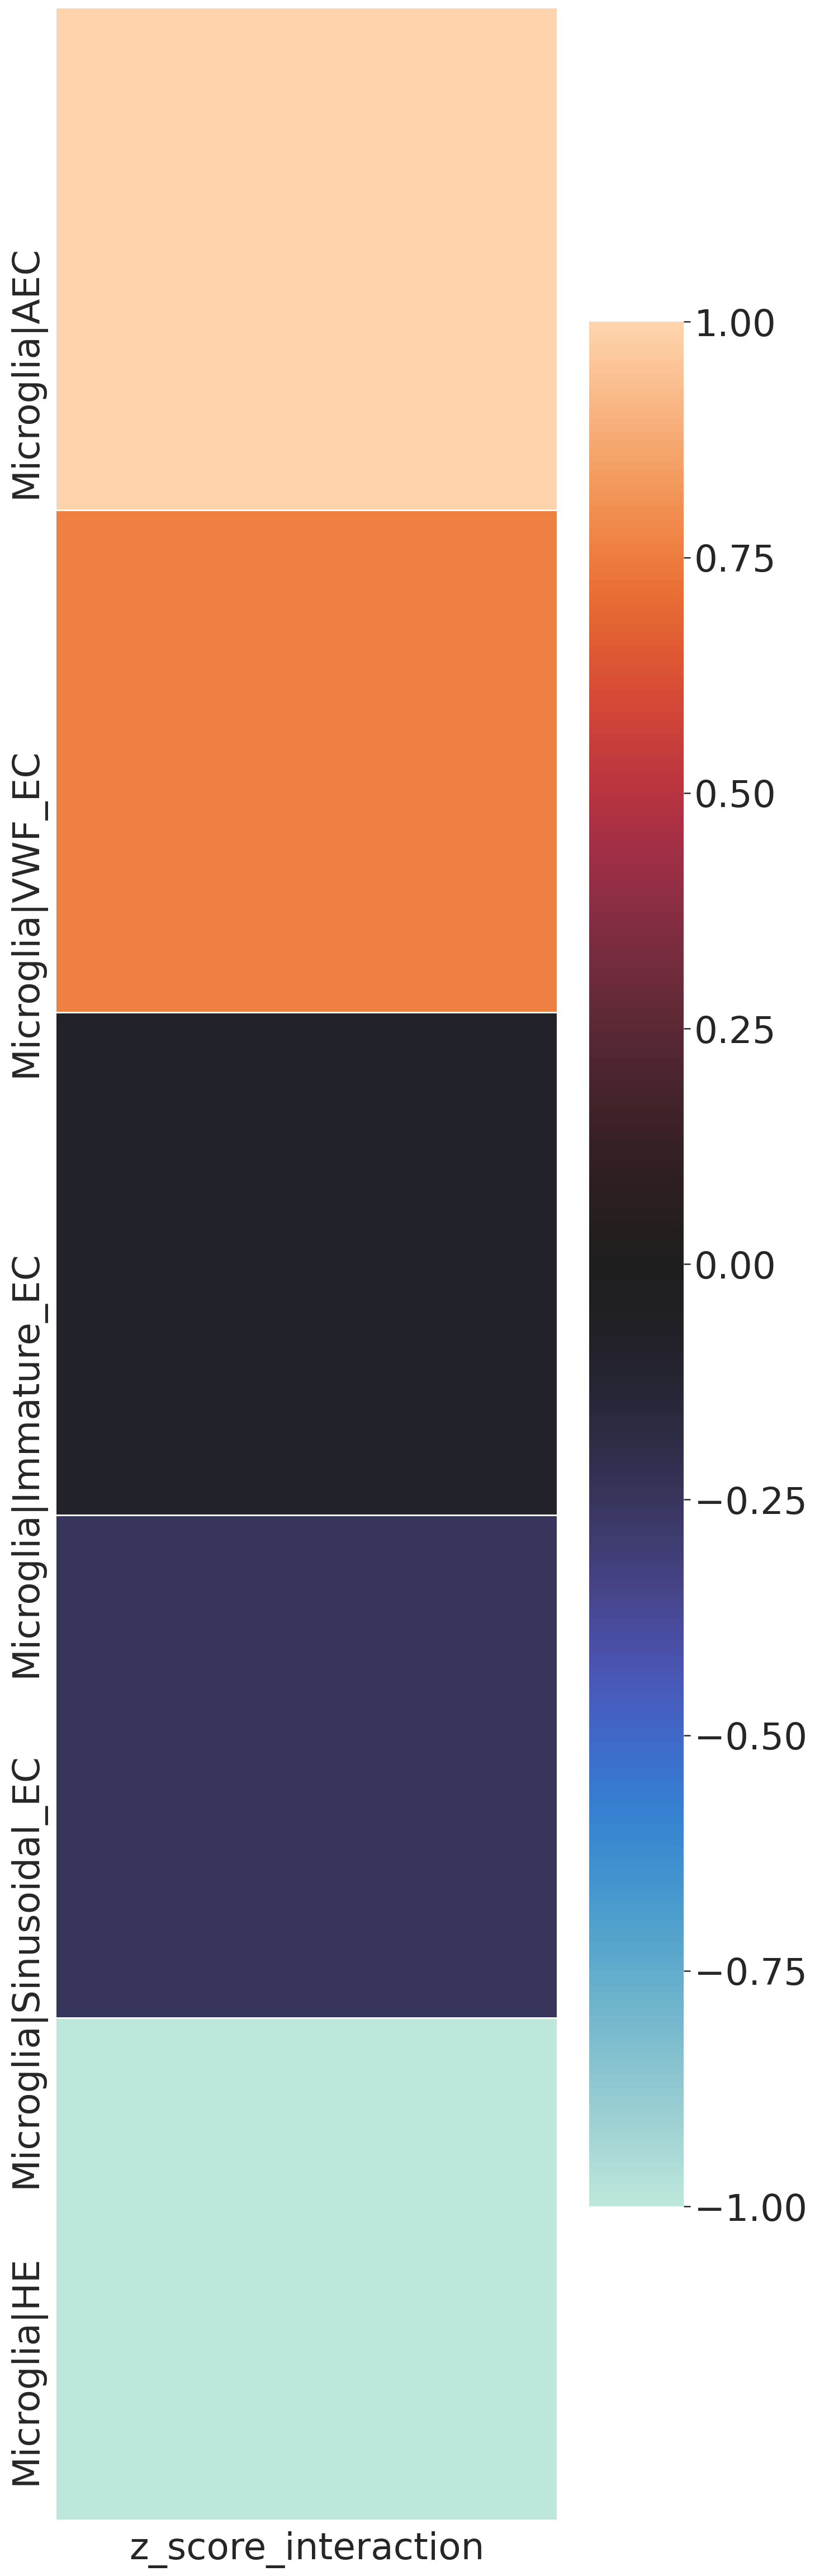

In [82]:
# Make heatmap for mean interactions socres
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Microglia')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Microglia')])].fillna(0)
#cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.contains('Microglia')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
ranking_col.columns = ['z_score_interaction']
ranking_col.iloc[:,0] = stats.zscore(list(ranking_col.iloc[:,0]))
sns.heatmap(ranking_col,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

In [128]:
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Endoderm')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Endoderm')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp[list(ranking_col.index)]
# Remove 0 interacting rows
cpdb_tmp = cpdb_tmp.loc[(cpdb_tmp.sum(axis=1) != 0), (cpdb_tmp.sum(axis=0) != 0)]

<ipython-input-128-7d3658b80547>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Endoderm')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Endoderm')])].fillna(0)


# Q3 Which subsets of EC most communicate with Macs?

In [48]:
cpdb = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/cpdb_microglia_EC_communication/cpdb_out/significant_means.txt', delimiter = "\t",index_col=0)
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20211111_with_obsp.h5ad')

In [49]:
keep = [
#'Endoderm',
'Sinusoidal_EC',
'Immature_EC',
# 'Prolif_Sinusoidal_EC',
 'AEC',
 'HE',
 'Macrophage',
#  'Monocyte',
#  'Microglia',
#  'Pre_Macrophage',
 'VWF_EC',
#  'Prolif_AEC',
]

from itertools import product
combi = (pd.DataFrame(product(keep,keep)))
combi['combi'] = combi.iloc[:,0].astype(str) + "|" +combi.iloc[:,1].astype(str)
cpdb_metrics = ['interacting_pair',
 'partner_a',
 'partner_b',
 'gene_a',
 'gene_b',
 'secreted',
 'receptor_a',
 'receptor_b',
 'annotation_strategy',
 'is_integrin',
 'rank',]
cpdb_interaction = cpdb[cpdb_metrics+list(combi['combi'])]

<ipython-input-52-9df10dd3e901>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Macrophage')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Macrophage')])].fillna(0)


<AxesSubplot:ylabel='interacting_pair'>

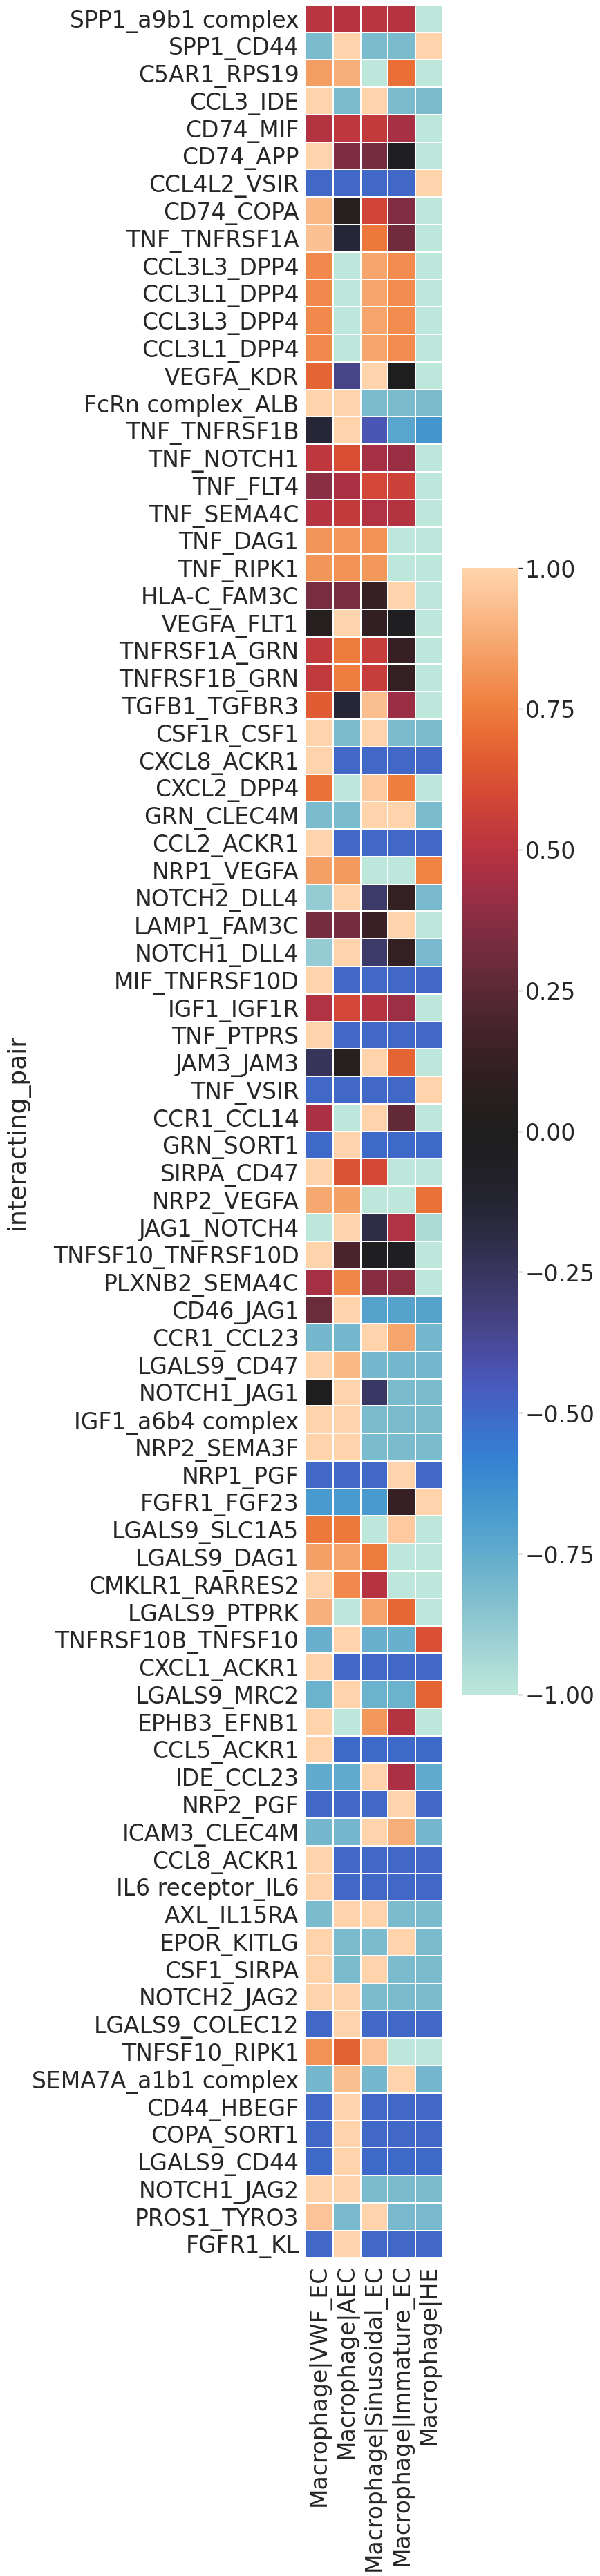

In [52]:
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Macrophage')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Macrophage')])].fillna(0)
#cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.contains('Microglia')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp[list(ranking_col.index)]
# Remove 0 interacting rows
cpdb_tmp = cpdb_tmp.loc[(cpdb_tmp.sum(axis=1) != 0), (cpdb_tmp.sum(axis=0) != 0)]
cpdb_tmp =  pd.concat([cpdb_interaction[cpdb_metrics][cpdb_interaction.index.isin(cpdb_tmp.index)] ,cpdb_tmp], axis = 1)#add metrics back
# cpdb_tmp[cpdb_metrics] = cpdb_interaction[cpdb_metrics][cpdb_interaction.index.isin(cpdb_tmp.index)] #add metrics back
# Raning rows and reorder
ranking_row =  pd.DataFrame(cpdb_tmp[cpdb_tmp.columns[~cpdb_tmp.columns.isin(cpdb_metrics)]].sum(axis=1, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp.T[list(ranking_row.index)].T
cpdb_tmp_plot = cpdb_tmp.drop((cpdb_metrics[0:len(cpdb_metrics)]),axis = 1)

import scipy.stats as stats
cpdb_tmp_plot = cpdb_tmp_plot.T
for i in list(range(0,len(cpdb_tmp_plot.columns))):
    cpdb_tmp_plot.iloc[:,i] = stats.zscore(list(cpdb_tmp_plot.iloc[:,i]))
cpdb_tmp_plot = cpdb_tmp_plot.T
cpdb_tmp_plot[cpdb_metrics[0]] = cpdb_tmp[cpdb_metrics[0]]


cpdb_tmp_plot.index = cpdb_tmp_plot['interacting_pair']
cpdb_tmp_plot = cpdb_tmp_plot.drop(['interacting_pair'],axis = 1)
sns.heatmap(cpdb_tmp_plot,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

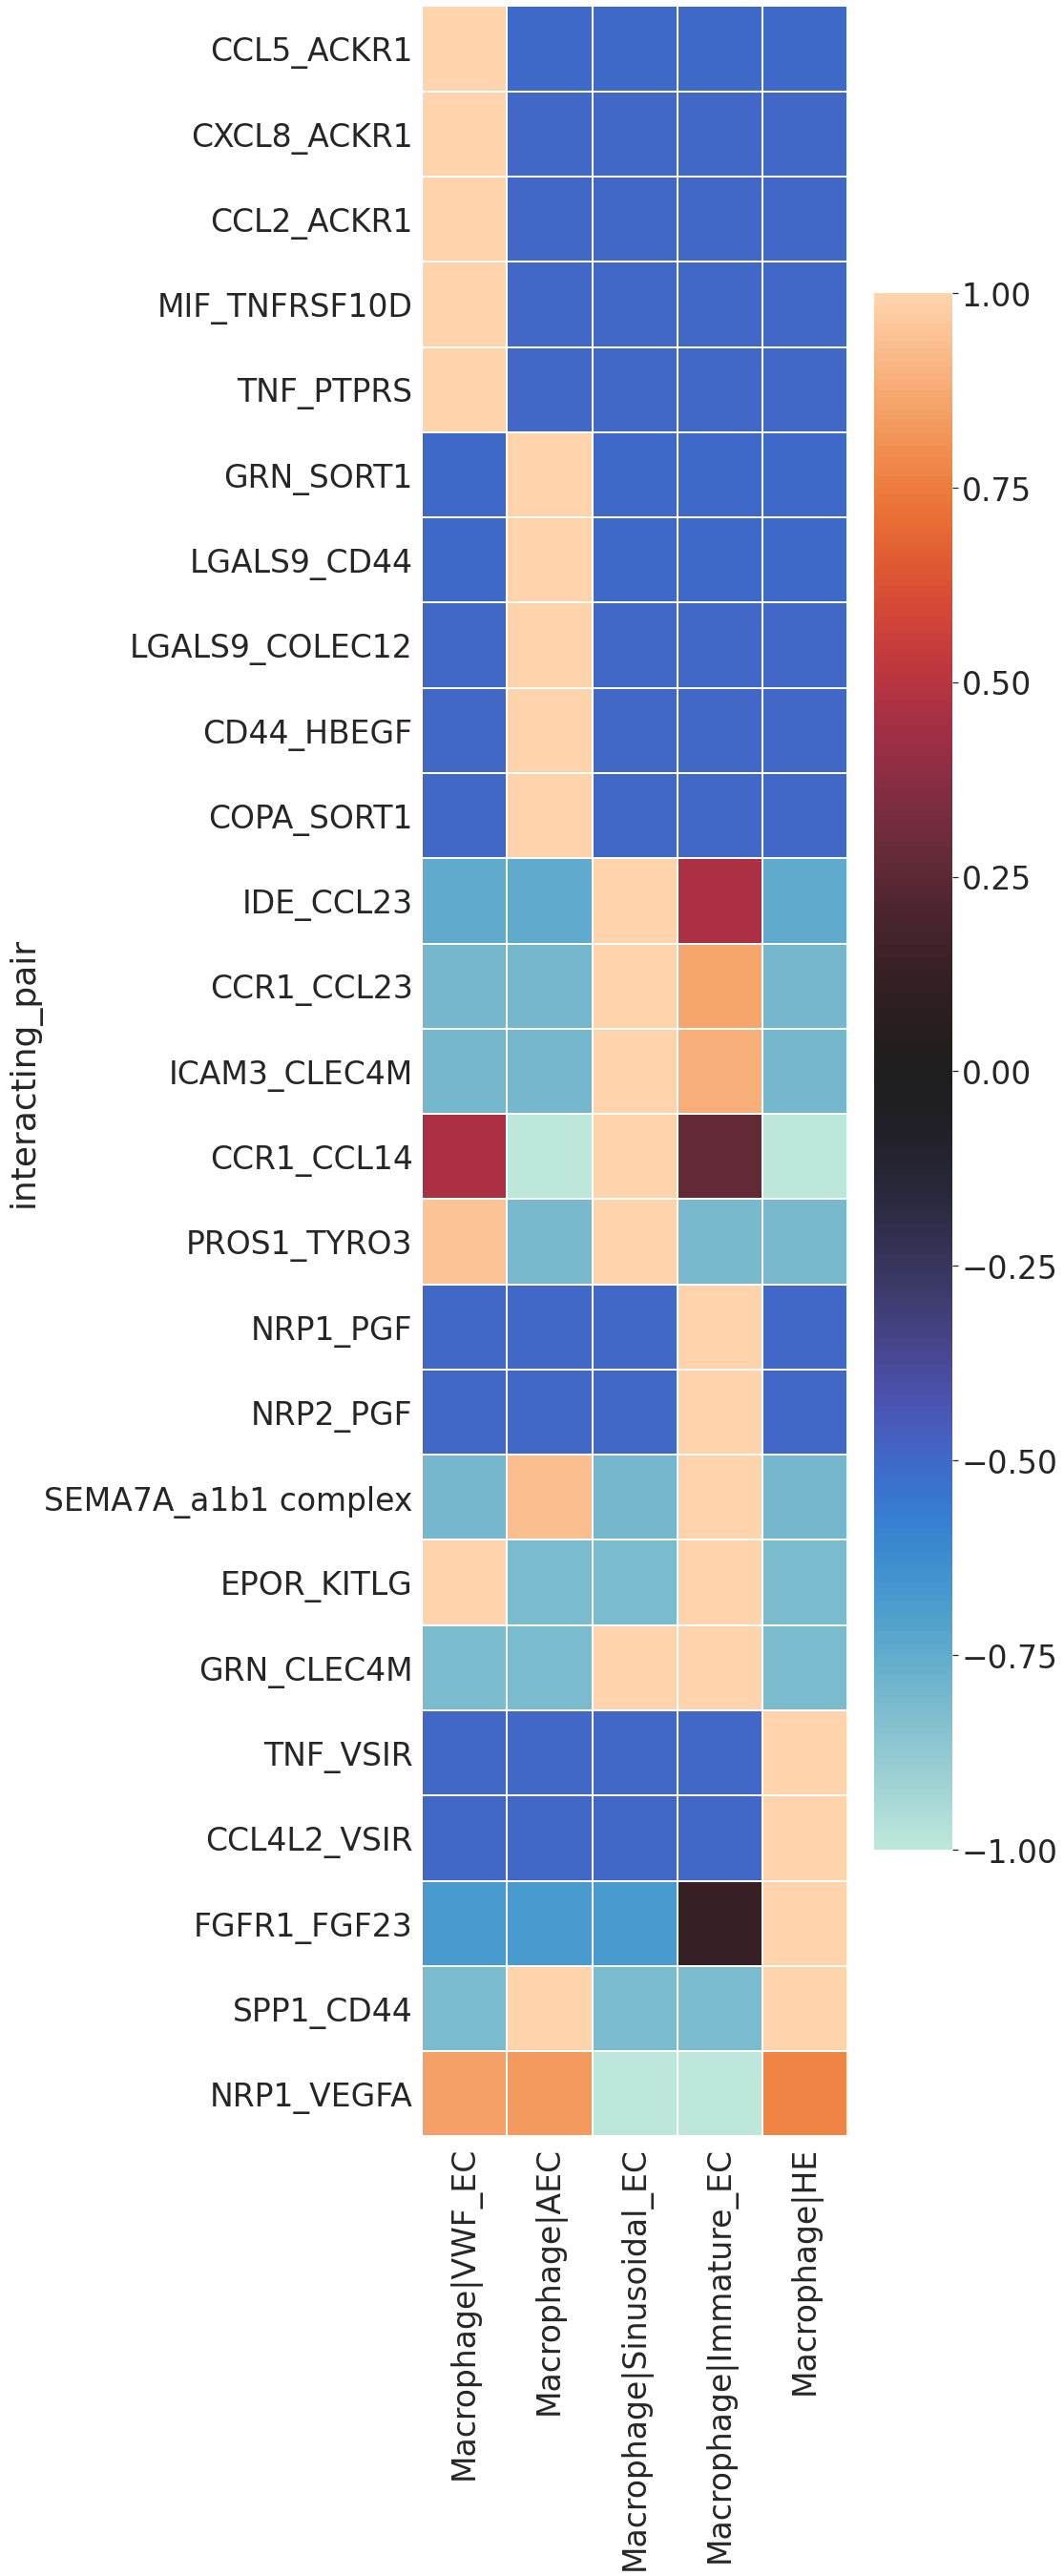

In [56]:
keep = []
for i in ranking_col.index:
    keep.extend(list(cpdb_tmp_plot[i].nlargest(5).index))
cpdb_tmp_plot_top = cpdb_tmp_plot.T[keep].T
fig = sns.heatmap(cpdb_tmp_plot_top,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})
fig = fig.get_figure()
fig.savefig(bbox_inches='tight',fname = 'top_macrophage_EC_interactions.pdf')

In [54]:
[cpdb_tmp_plot_top.columns]

[Index(['Macrophage|VWF_EC', 'Macrophage|AEC', 'Macrophage|Sinusoidal_EC',
        'Macrophage|Immature_EC', 'Macrophage|HE'],
       dtype='object')]

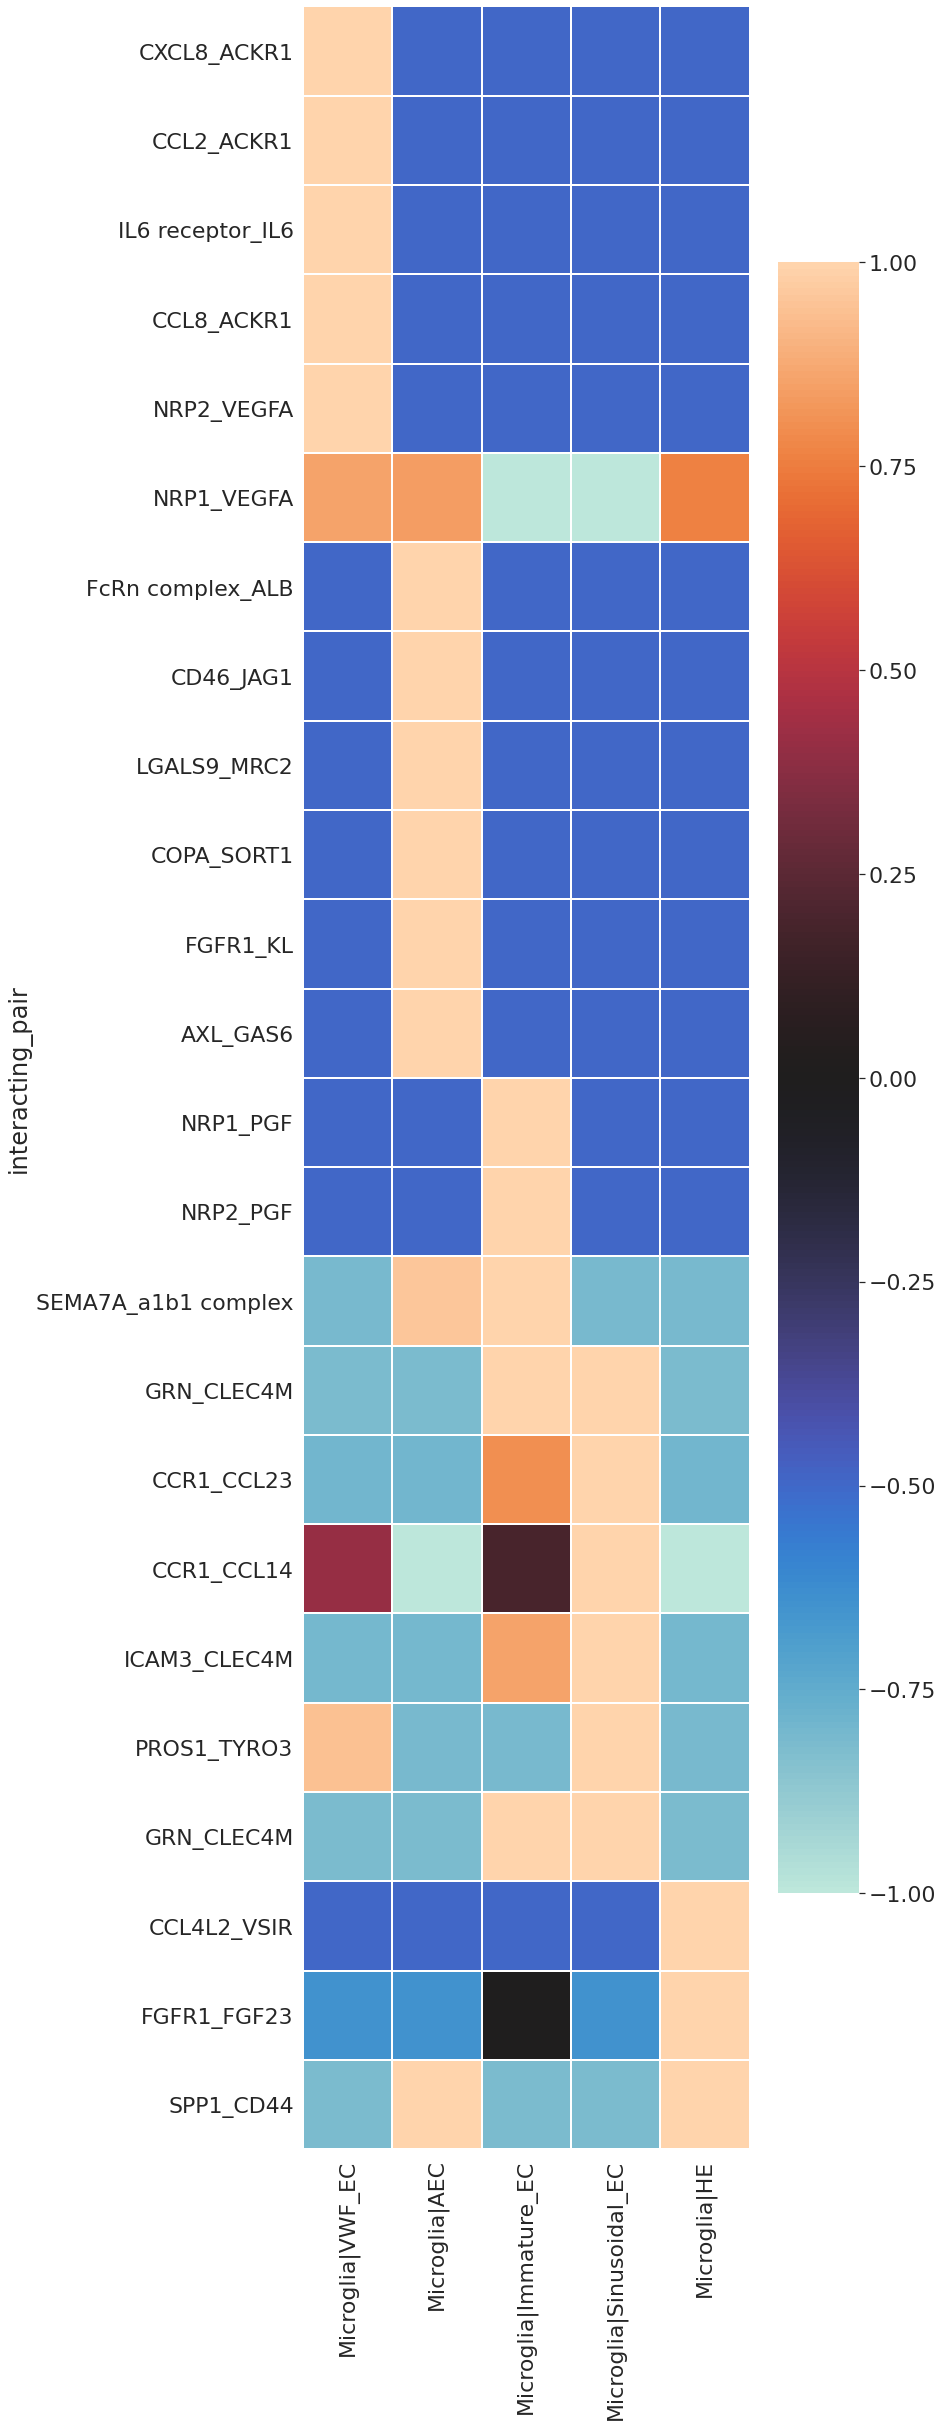

In [7]:
keep = [
 'CXCL8_ACKR1',
 'CCL2_ACKR1',
 'IL6 receptor_IL6',
 'CCL8_ACKR1',
 'NRP2_VEGFA',
   'NRP1_VEGFA',  
'FcRn complex_ALB',
 'CD46_JAG1',
 'LGALS9_MRC2',
 'COPA_SORT1',
 'FGFR1_KL',
 'AXL_GAS6',

 'NRP1_PGF',
 'NRP2_PGF',
 'SEMA7A_a1b1 complex',
 'GRN_CLEC4M',
 'CCR1_CCL23',
 'CCR1_CCL14',
 'ICAM3_CLEC4M',
 'PROS1_TYRO3',
 'GRN_CLEC4M',
 'CCL4L2_VSIR',
 'FGFR1_FGF23',
 'SPP1_CD44',]
cpdb_tmp_plot_top = cpdb_tmp_plot.T[keep].T
cpdb_tmp_plot_top = cpdb_tmp_plot_top[['Microglia|VWF_EC','Microglia|AEC', 'Microglia|Immature_EC','Microglia|Sinusoidal_EC', 'Microglia|HE']]
sns.set(font_scale = 3)
fig = sns.heatmap(cpdb_tmp_plot_top,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})
fig = fig.get_figure()
fig.savefig(bbox_inches='tight',fname = 'top_microglia_EC_interactions.pdf')

# Create GSEA ranking for each interaction set

In [57]:
keep = {}
for i in ranking_col.index:
#     keep[i] = list(cpdb_tmp[['gene_a']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str)) + list(cpdb_tmp[['gene_b']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(5).index))].iloc[:,0].astype(str))
    keep[i] = list(cpdb_tmp[['gene_a']][cpdb_tmp['interacting_pair'].isin((cpdb_tmp_plot[i].nlargest(10).index))].iloc[:,0].astype(str)) 

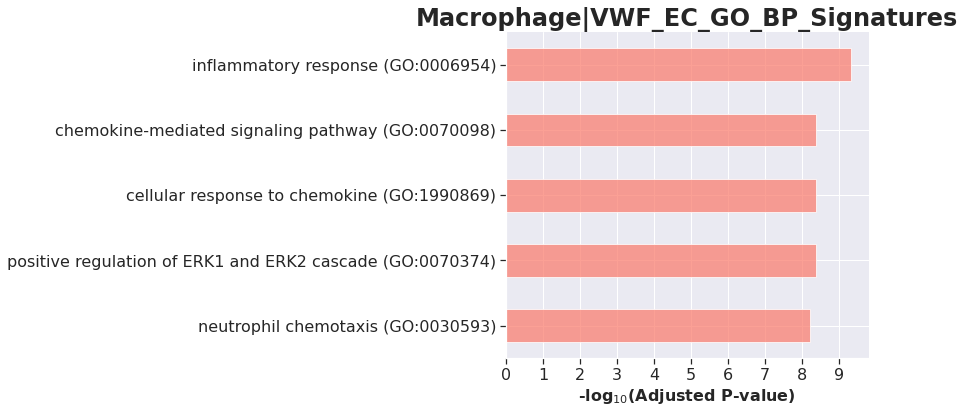

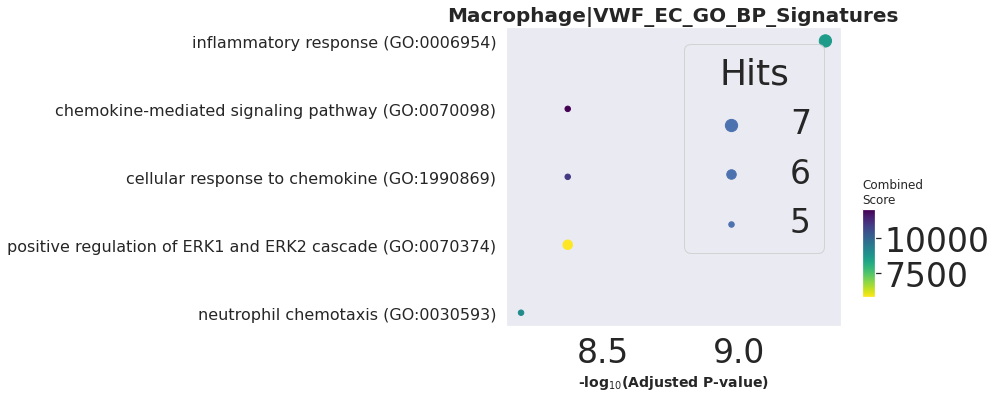

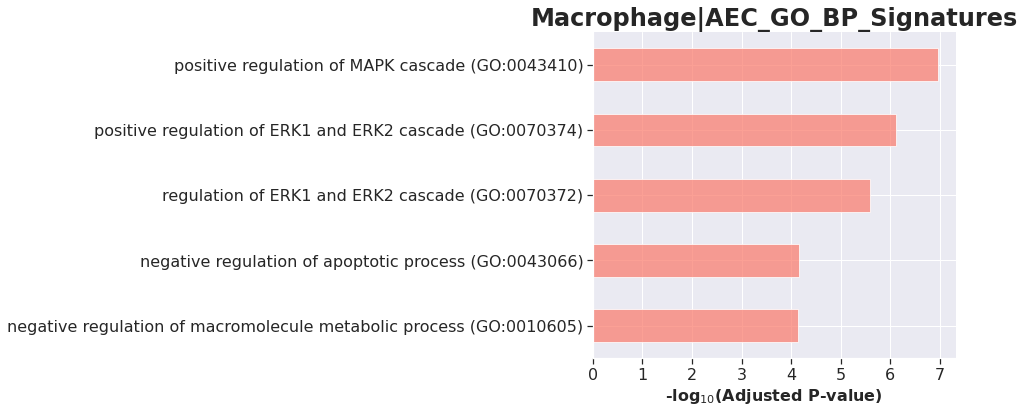

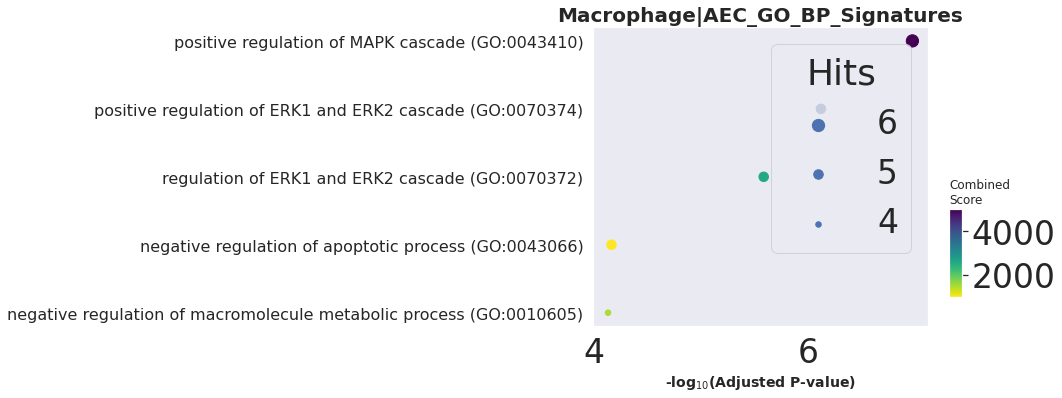

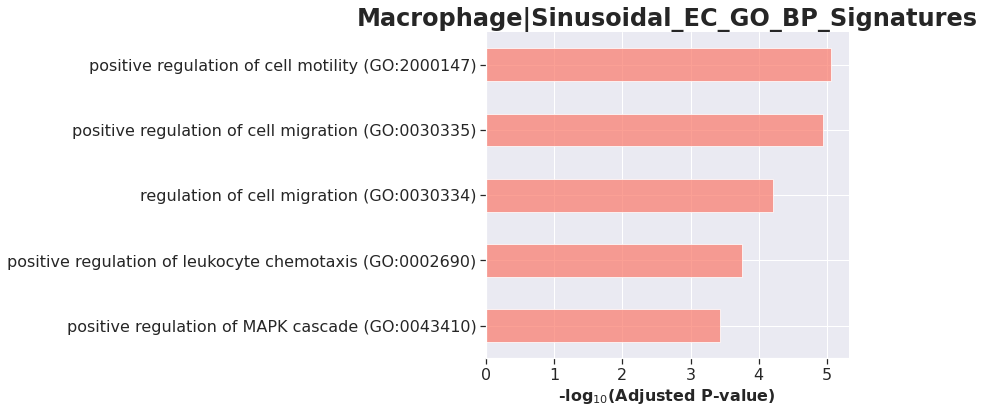

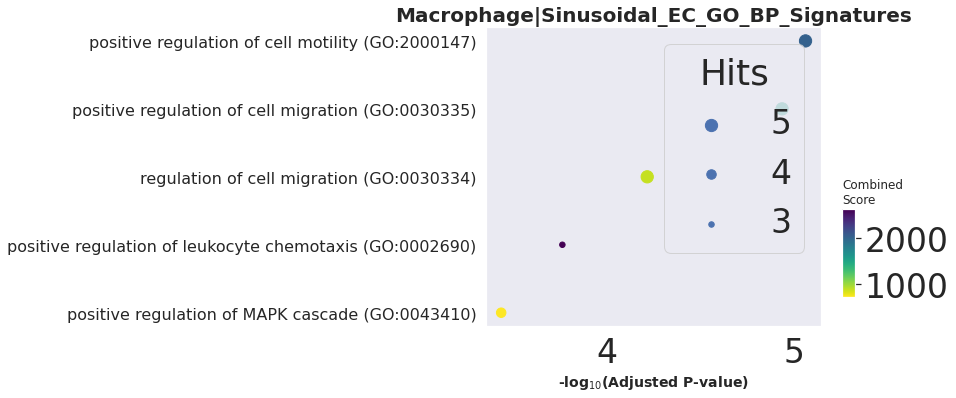

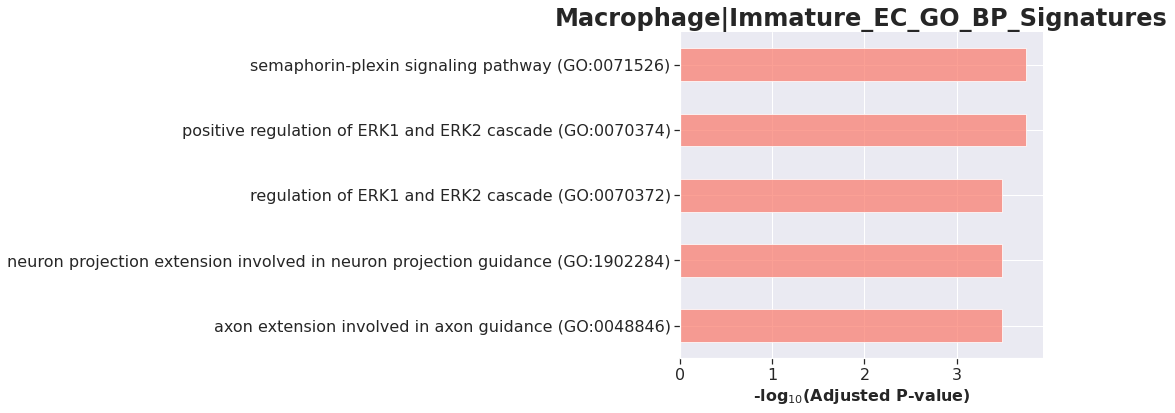

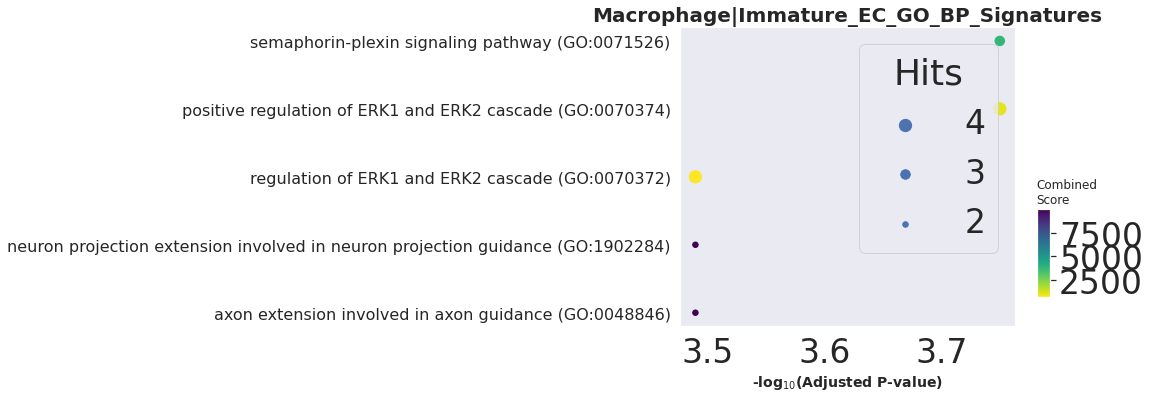

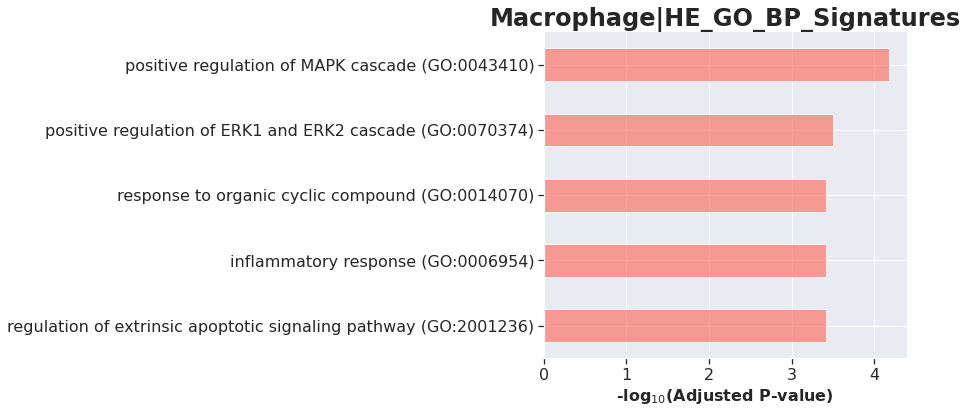

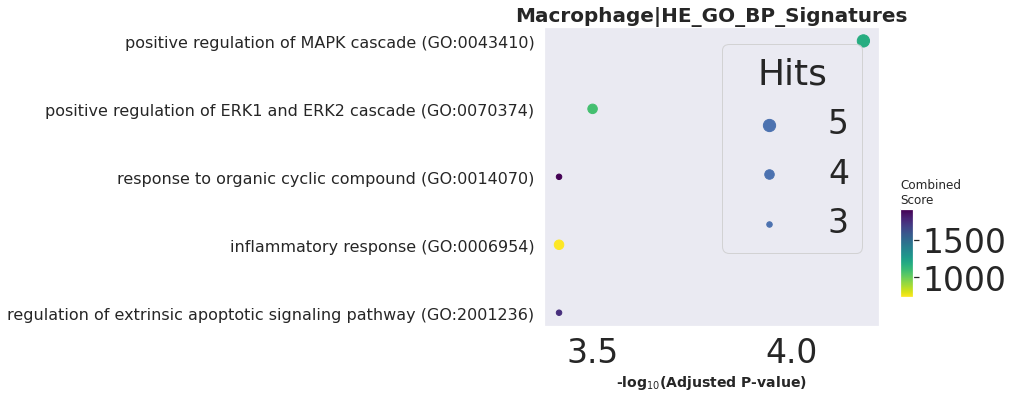

In [59]:
import gseapy
gene_set_names = gseapy.get_library_name(database='Human')

for i in keep.keys():
    #Available databases : 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' 
    import gseapy
    gene_set_names = gseapy.get_library_name(database='Human')
    glist = keep[i]
    glist = [x for x in glist if x != 'nan']
                                
    enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021' ,#'GO_Molecular_Function_2021', #''GO_Biological_Process_2021',
                     description='pathway',
                     cutoff = 0.05)
    enr_res.res2d.to_csv('./'+i+'_enr_res_score.csv')
    gseapy.barplot(enr_res.res2d,title=(i+ '_GO_BP_Signatures'),top_term=5)
    gseapy.dotplot(enr_res.res2d, title=(i+'_GO_BP_Signatures'),cmap='viridis_r',top_term=5)

<ipython-input-348-52ecd6bbab70>:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Microglia')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Microglia')])].fillna(0)


<AxesSubplot:>

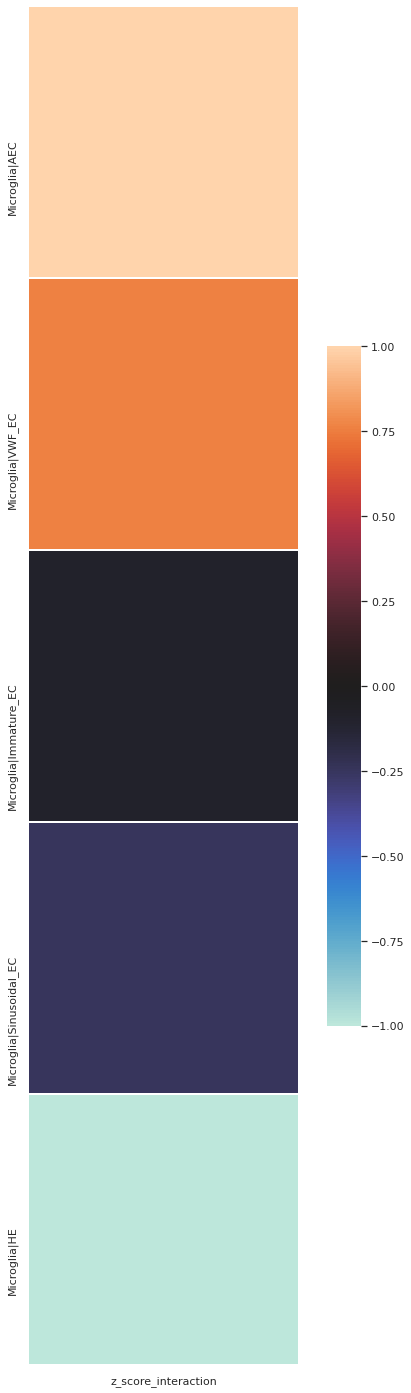

In [348]:
# Make heatmap for mean interactions socres
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Microglia')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Microglia')])].fillna(0)
#cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.contains('Microglia')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
ranking_col.columns = ['z_score_interaction']
ranking_col.iloc[:,0] = stats.zscore(list(ranking_col.iloc[:,0]))
sns.heatmap(ranking_col,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

# Slice interactions

In [273]:
# list(cpdb_tmp_plot['interacting_pair'])

['VTN_aVb1 complex',
 'MIF_TNFRSF10D',
 'MIF_TNFRSF14',
 'DLK1_NOTCH4',
 'FN1_a5b1 complex',
 'FN1_aVb1 complex',
 'FN1_aVb5 complex',
 'VEGFA_KDR',
 'EGFR_MIF',
 'IGF2_IGF1R',
 'AGT_AGTR1',
 'FN1_a8b1 complex',
 'FN1_a2b1 complex',
 'IGF2_IGF2R',
 'CD74_MIF',
 'IGF2_IDE',
 'VEGFA_FLT1',
 'EPO_EFNB2',
 'HLA-C_FAM3C',
 'PLD2_ARF1',
 'DLK1_NOTCH3',
 'EFNA1_EPHA2',
 'FN1_a3b1 complex',
 'EPO_EPHB4',
 'EFNA1_EPHA4',
 'EPO_EPOR',
 'EGFR_GRN',
 'EGFR_TGFB1',
 'CD46_JAG1',
 'LAMP1_FAM3C',
 'CD74_APP',
 'CXADR_FAM3C',
 'EGFR_HBEGF',
 'EGFR_COPA',
 'ICAM3_CLEC4M',
 'CDH1_a2b1 complex',
 'LAMC1_a6b1 complex',
 'TNFRSF1A_GRN',
 'TNFRSF10B_TNFSF10',
 'FGFR4_SCGB3A1',
 'PROS1_TYRO3',
 'FGFR1_FGF23',
 'VCAM1_a9b1 complex',
 'FGFR3_FGF23',
 'COL26A1_a1b1 complex',
 'PLXNB2_SEMA4C',
 'TNFRSF10C_TNFSF10',
 'ERBB3_NRG1',
 'EPHA4_EFNB1',
 'EPHB4_EFNB1',
 'FGFR4_EPHA4',
 'COL27A1_a1b1 complex',
 'EGFR_NRG1',
 'LAMC1_a2b1 complex',
 'CDH1_KLRG1',
 'EPHA1_EFNA4',
 'COL26A1_a2b1 complex',
 'COPA_SORT1',
 'COL27A1_a2b1 complex',
 'FAM3C_CLEC2D',
 'TNFSF12_TNFRSF25',
 'FGFR3_EPHA4',
 'EFNA4_EPHA4',
 'EFNA5_EPHA4',
 'IL6 receptor_IL6',
 'FGFR1_KL',
 'TNFSF12_TNFRSF12A',
 'ACVR_1B2B receptor_INHBA']

<AxesSubplot:ylabel='interacting_pair'>

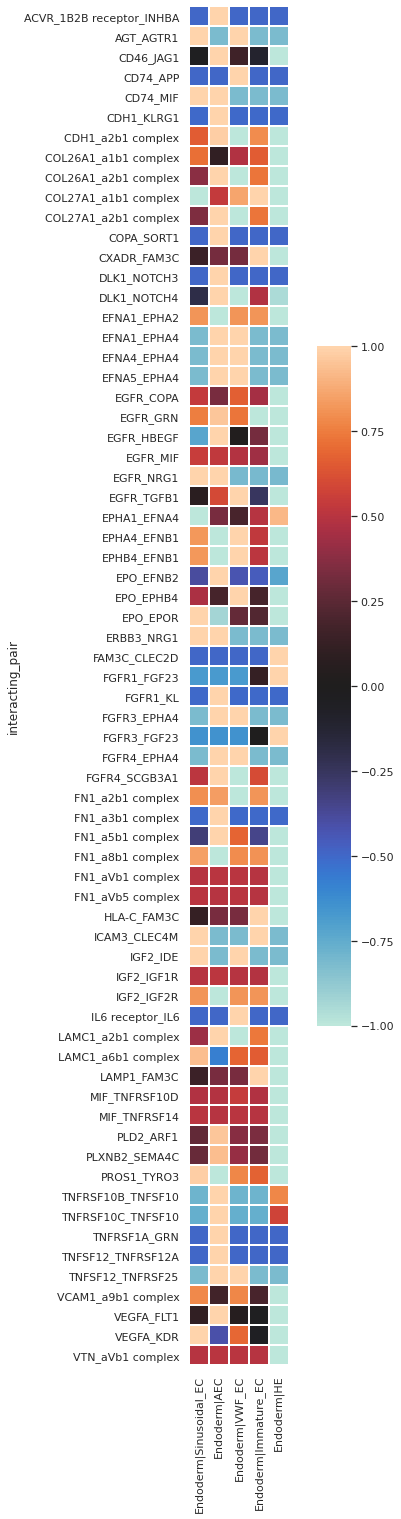

In [268]:
sns.heatmap(cpdb_tmp_plot.groupby('interacting_pair').median(),  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, square=True, cbar_kws={"shrink": 0.5})

In [128]:
cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Endoderm')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Endoderm')])].fillna(0)
# rankings and reorder
ranking_col = pd.DataFrame(cpdb_tmp.sum(axis=0, skipna=True, level=None)).sort_values(by=[0],ascending=False)
cpdb_tmp = cpdb_tmp[list(ranking_col.index)]
# Remove 0 interacting rows
cpdb_tmp = cpdb_tmp.loc[(cpdb_tmp.sum(axis=1) != 0), (cpdb_tmp.sum(axis=0) != 0)]

<ipython-input-128-7d3658b80547>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cpdb_tmp = cpdb_interaction[(cpdb_interaction.columns[cpdb_interaction.columns.str.startswith('Endoderm')]) & (cpdb_interaction.columns[~cpdb_interaction.columns.str.endswith('Endoderm')])].fillna(0)


# Plot EC markers

In [21]:
list(adata.obs['cell.labels'].unique())

['Sinusoidal_EC',
 'MEMP',
 'HSPC_1',
 'Erythroid',
 'Endoderm',
 'Immature_EC',
 'Macrophage',
 'MK',
 'Early_Erythroid',
 'Lymphoid_progenitor',
 'Mesothelium',
 'Prolif_Sinusoidal_EC',
 'Fibroblast',
 'HSPC_2',
 'AEC',
 'Mast_cell',
 'MOP',
 'CMP',
 'Mono Mac pre DC2',
 'HE',
 'Monocyte',
 'LMPP',
 'Neutrophil_precursor',
 'Microglia',
 'Smooth_Muscle',
 'Promonocyte',
 'Eo_Baso_Mast_precursor',
 'ILC_precursor',
 'Pre_Macrophage',
 'VWF_EC',
 'Eo_Basophil',
 'Prolif_AEC',
 'NK',
 'Pre DC2',
 'Monocyte_Macrophage',
 'Mono Mac DC2',
 'pDC precursor',
 'Cycling DC2',
 'Mac DC2']

In [28]:
adata_ec = adata[adata.obs['cell.labels'].isin(['Sinusoidal_EC',
 'Immature_EC',
 'Prolif_Sinusoidal_EC',
 'AEC',
 'HE',
 'VWF_EC',
 'Prolif_AEC',
])]

In [64]:
EC_function = {
'PANEXINS':['PANX1','PANX2'],
'PAR_receptos':['F2R','F2RL1','F2RL2'],
'Firbronogen_receptors':[],
'IGF2_EC':['IGF2','IDE']
}

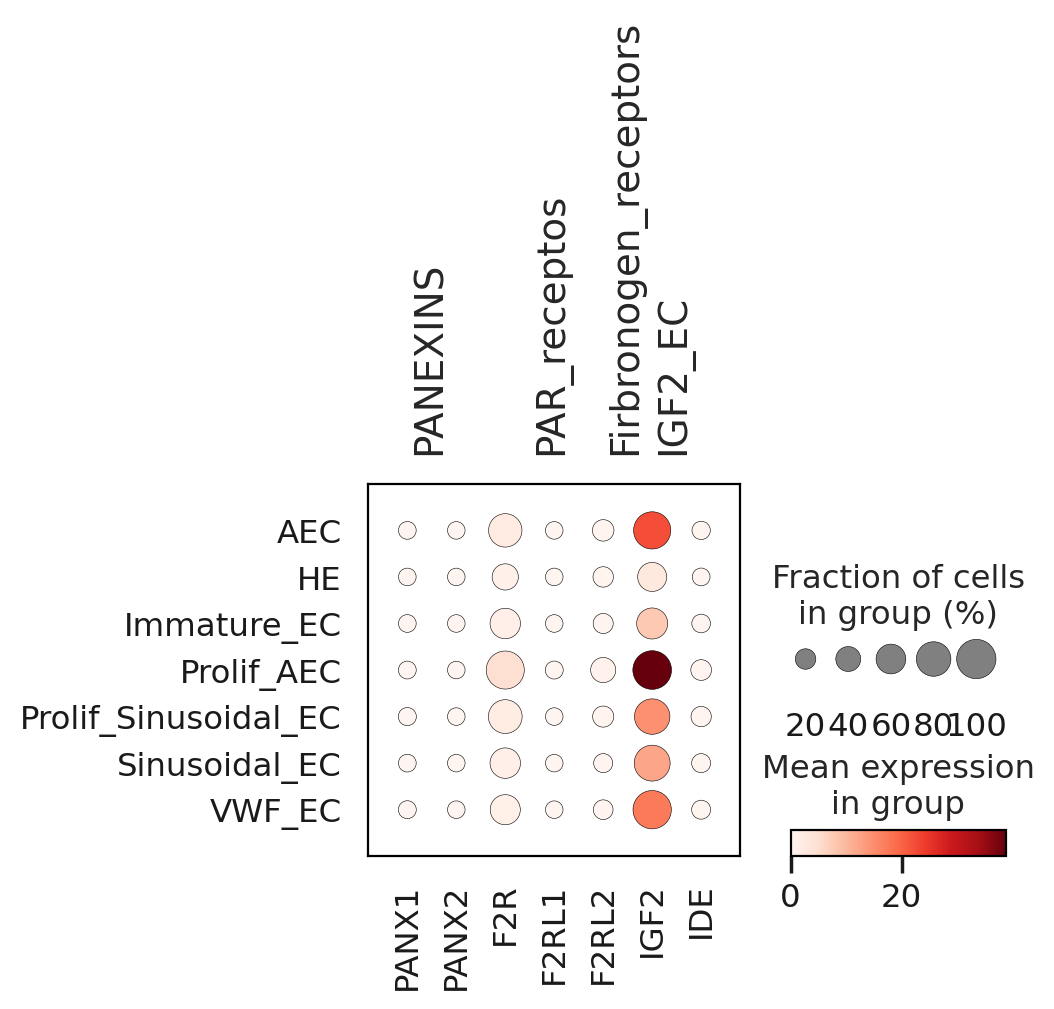

In [63]:
sc.settings.set_figure_params(dpi=100, color_map='viridis')
plt.rcParams['figure.figsize'] = [10, 5]
sc.pl.dotplot(adata_ec,groupby='cell.labels',var_names= EC_function,smallest_dot=40,expression_cutoff=0.1)